# **Тема 6. Реализация гибридной модели рекомендаций**
---


## 1 часть – общий пример (2 балла)

Цель: научиться использовать библиотеку LightFM для построения гибридной рекомендательной системы, а также оценить качество полученной модели на реальных данных.

Ход работы:


### 1.	Установить библиотеку LightFM

In [ ]:
!pip install lightfm

### 2.	Выполнить импорт необходимых библиотек

In [ ]:
from lightfm import LightFM

from lightfm.datasets import fetch_movielens # Для использования встроенного в LightFM набора данных Movielens

from lightfm.evaluation import precision_at_k, auc_score


### 3. Подготовка данных

Функция fetch_movielens загружает набор данных Movielens и возвращает словарь, содержащий матрицу оценок, пользовательские функции, характеристики элементов и другую информацию. В построении данной рек. системы нас интересует только матрица оценок.


In [ ]:
data = fetch_movielens(min_rating=5.0)
data
# data = fetch_movielens(min_rating=4.0)
# data = fetch_movielens(min_rating=3.0)
# Попробовать для разных минимальных рейтингов.


{'train': <COOrdinate sparse matrix of dtype 'int32'
 	with 19048 stored elements and shape (943, 1682)>,
 'test': <COOrdinate sparse matrix of dtype 'int32'
 	with 2153 stored elements and shape (943, 1682)>,
 'item_features': <Compressed Sparse Row sparse matrix of dtype 'float32'
 	with 1682 stored elements and shape (1682, 1682)>,
 'item_feature_labels': array(['T', 'G', 'F', ..., 'S', 'Y', 'S'], dtype='<U1'),
 'item_labels': array(['T', 'G', 'F', ..., 'S', 'Y', 'S'], dtype='<U1')}

In [ ]:
data = fetch_movielens(min_rating=5.0)

print("Число пользователей:", data['train'].shape[0])
print("Число фильмов:", data['train'].shape[1])
print("Жанры первого фильма:", data['item_labels'][0]) #  'T' (Thriller)

Число пользователей: 943
Число фильмов: 1682
Жанры первого фильма: T


Основные компоненты:
'train' и 'test'
Тип: Разреженные (sparse) матрицы в формате COOrdinate (COO)

Формат: (пользователи, фильмы)

Данные:

'train': 19048 ненулевых элементов (рейтингов 5 звёзд в обучающей выборке)

'test': 2153 ненулевых элементов (рейтингов 5 звёзд в тестовой выборке)

Размер: 943 пользователя × 1682 фильма (как в MovieLens 100K)

'item_features'
Тип: Разреженная матрица в формате Compressed Sparse Row (CSR)

Размер: (1682, 1682) (один-hot кодировка жанров фильмов)

Данные: Диагональная матрица (каждый фильм имеет свою уникальную метку).

'item_feature_labels' и 'item_labels'
Тип: Массивы строк (жанры фильмов в виде буквенных кодов)

Пример: ['T', 'G', 'F', ..., 'S', 'Y', 'S']

'T' — Thriller, 'G' — Adventure, 'F' — Fantasy и т.д.

Полный список жанров MovieLens: Adventure (A), Comedy (C), Action (G), etc.

In [ ]:
data = fetch_movielens(min_rating=4.0)
data

{'train': <COOrdinate sparse matrix of dtype 'int32'
 	with 49906 stored elements and shape (943, 1682)>,
 'test': <COOrdinate sparse matrix of dtype 'int32'
 	with 5469 stored elements and shape (943, 1682)>,
 'item_features': <Compressed Sparse Row sparse matrix of dtype 'float32'
 	with 1682 stored elements and shape (1682, 1682)>,
 'item_feature_labels': array(['T', 'G', 'F', ..., 'S', 'Y', 'S'], dtype='<U1'),
 'item_labels': array(['T', 'G', 'F', ..., 'S', 'Y', 'S'], dtype='<U1')}

In [ ]:
data = fetch_movielens(min_rating=3.0)
data

{'train': <COOrdinate sparse matrix of dtype 'int32'
 	with 74627 stored elements and shape (943, 1682)>,
 'test': <COOrdinate sparse matrix of dtype 'int32'
 	with 7893 stored elements and shape (943, 1682)>,
 'item_features': <Compressed Sparse Row sparse matrix of dtype 'float32'
 	with 1682 stored elements and shape (1682, 1682)>,
 'item_feature_labels': array(['T', 'G', 'F', ..., 'S', 'Y', 'S'], dtype='<U1'),
 'item_labels': array(['T', 'G', 'F', ..., 'S', 'Y', 'S'], dtype='<U1')}

###  4. Реализация гибридной рекомендательной системы

Для реализации рекомендательной системы с lightFM предпочтительным алгоритмом является WARP (Weighted Approximate-Rank Pairwise).

In [ ]:
model = LightFM(loss='warp')

model.fit(data['train'], epochs=30, num_threads=2)

### 5. Генерация рекомендаций

Используем созданную модель для генерации рекомендаций для пользователей, вызвав метод recommend. Метод recommend принимает два аргумента: user_ids и item_ids . Мы можем генерировать рекомендации для одного пользователя или нескольких пользователей одновременно. Мы также можем указать количество рекомендаций для генерации. Следующий код генерирует 10 рекомендаций для пользователя 3.

In [ ]:
import numpy as np

user_id = 3

n_items = data['train'].shape[1]

recommendations = model.predict(user_id, np.arange(n_items))

top_items = np.argsort(-recommendations)[:10]

In [ ]:
recommendations

array([-1.0409337, -2.3892398, -0.7805722, ..., -1.4998691, -1.4173601,
       -1.2684937], dtype=float32)

In [ ]:
top_items

array([299, 257, 326, 897, 689, 325, 878, 244, 358, 327])

### 6. Оценка рекомендательной системы

Оцените производительность модели, используя метрики precision at k и AUC. Метрика precision at k измеряет процент рекомендаций, которые были релевантны пользователю, из числа k лучших рекомендаций. Метрика AUC измеряет площадь под кривой рабочей характеристики приемника (ROC), которая показывает частоту истинных положительных срабатываний по сравнению с частотой ложных положительных срабатываний.
Мы можем использовать библиотеку LightFM для вычисления этих показателей. Точность из k рекомендаций может быть рассчитана с помощью метода precision_at_k, а AUC может быть рассчитан с помощью метода auc_score.
В этом примере мы обучаем модель на основе матрицы взаимодействий и оцениваем точность по метрикам k и AUC как для обучающего, так и для тестового наборов данных. Мы используем значение 10 для k, что означает, что мы рассматриваем только 10 лучших рекомендаций для каждого пользователя.
Необходимо также попробовать вариант модели для k = 5.

In [ ]:
# Оцениваем модель на обучающих данных, количество потоков – 2,
# можно варьировать
train_precision = np.mean(precision_at_k(model, data['train'], k=10, num_threads=2))

train_auc = np.mean(auc_score(model, data['train'], num_threads=2))

# Оцениваем модель на тестовых данных.
test_precision = np.mean(precision_at_k(model, data['test'], k=10, num_threads=2))

test_auc = np.mean(auc_score(model, data['test'], num_threads=2))

print('Train precision: {:.2f}'.format(train_precision))
print('Train AUC: {:.2f}'.format(train_auc))
print('Test precision: {:.2f}'.format(test_precision))
print('Test AUC: {:.2f}'.format(test_auc))

Train precision: 0.35
Train AUC: 0.97
Test precision: 0.04
Test AUC: 0.92


### 7. Анализ результатов



**Precision@10**

Train=0.35: Хорошо — 35% рекомендаций верные.

Test=0.04: Очень плохо — модель не работает на новых данных.
Причина: Переобучение + мало данных (только оценки 5).

**AUC**

Train=0.97 и Test=0.92: Отлично — модель правильно ранжирует фильмы (релевантные выше).
Почему лучше Precision?: AUC смотрит на порядок рекомендаций, а не точный топ-k.

То что было в ворде:
Train precision: 0.51
Train AUC: 0.95
Test precision: 0.08
Test AUC: 0.92


### Моя реализация

In [ ]:
for min_rating in [5.0, 4.0, 3.0]:
    print(f"\n=== Минимальный рейтинг: {min_rating} ===")
    data = fetch_movielens(min_rating=min_rating)

    # гибридная рек система
    model = LightFM(loss='warp')
    model.fit(data['train'], epochs=30, num_threads=2)

    # генерация рекомендаций для пользователя
    user_id = 3
    n_items = data['train'].shape[1]
    recommendations = model.predict(user_id, np.arange(n_items))
    top_items = np.argsort(-recommendations)[:10]
    print(f"\nТоп-10 рекомендаций для пользователя {user_id}:")
    print(top_items)

    # оценка модели для k=10 и k=5
    for k in [10, 5]:
        print(f"\nМетрики для k={k}:")
        # на обучающих
        train_precision = np.mean(precision_at_k(model, data['train'], k=k, num_threads=2))
        train_auc = np.mean(auc_score(model, data['train'], num_threads=2))

        # на тестовых
        test_precision = np.mean(precision_at_k(model, data['test'], k=k, num_threads=2))
        test_auc = np.mean(auc_score(model, data['test'], num_threads=2))

        print('Train precision: {:.2f}'.format(train_precision))
        print('Train AUC: {:.2f}'.format(train_auc))
        print('Test precision: {:.2f}'.format(test_precision))
        print('Test AUC: {:.2f}'.format(test_auc))


=== Минимальный рейтинг: 5.0 ===

Топ-10 рекомендаций для пользователя 3:
[305 285 257 749 897 312 326 325 323 331]

Метрики для k=10:
Train precision: 0.35
Train AUC: 0.97
Test precision: 0.04
Test AUC: 0.92

Метрики для k=5:
Train precision: 0.41
Train AUC: 0.97
Test precision: 0.05
Test AUC: 0.92

=== Минимальный рейтинг: 4.0 ===

Топ-10 рекомендаций для пользователя 3:
[287 257 301 332 285 306 312 267 299 345]

Метрики для k=10:
Train precision: 0.53
Train AUC: 0.96
Test precision: 0.08
Test AUC: 0.92

Метрики для k=5:
Train precision: 0.57
Train AUC: 0.96
Test precision: 0.09
Test AUC: 0.92

=== Минимальный рейтинг: 3.0 ===

Топ-10 рекомендаций для пользователя 3:
[301 299 327 257 312 287 331 268 332 326]

Метрики для k=10:
Train precision: 0.61
Train AUC: 0.95
Test precision: 0.10
Test AUC: 0.91

Метрики для k=5:
Train precision: 0.65
Train AUC: 0.95
Test precision: 0.11
Test AUC: 0.91


**Краткий вывод по результатам:**


Чем строже фильтр (min_rating), тем хуже качество рекомендаций:

Precision@k падает на тесте для k=10:

5★: 0.04 →

4★: 0.08 →

3★: 0.10.

AUC почти не меняется (~0.92), но для 5★ чуть лучше.


---

Чем больше данных (ниже min_rating), тем выше точность:


На 3★ модель показывает лучший Precision на тесте (0.10 vs 0.04 для 5★).
Но есть риск включения «шумных» оценок (3★ — не всегда явный лайк).



---


Размер топа (k) влияет на Precision:

Для k=5 Precision всегда выше, чем для k=10 (например, 0.11 vs 0.10 для 3★).

**AUC не зависит от k — это плюс метрики.**

---

Главный конфликт:

Высокий AUC (0.91-0.97): Модель хорошо ранжирует фильмы.

Низкий Test Precision (0.04-0.11): В топ-k попадает мало релевантных фильмов.

Это значит что для строгих рекомендаций (только 5★) модель работает плохо (Precision=0.04) из-за нехватки данных.А для более мягких условий (3★-4★) Precision выше, но часть рекомендаций может быть неточной.

AUC стабильно хорош — модель верно определяет «хорошие» фильмы, но не всегда помещает их в самый топ.

**Итог:** Лучший компромисс — min_rating=4.0 (Precision=0.08, AUC=0.92). Для более персонализированных рекомендаций нужно больше данных и настроек(можно использовать дополнительные признаки (жанры, возраст пользователей))

## 2 часть – реализация примера с Kaggle (2 балла)

Рассмотрите решение для конкурса рекомендательных систем Career Village
Конкурс проводился на платформе Kaggle https://www.kaggle.com/code/niyamatalmass/lightfm-hybrid-recommendation-system/notebook , также одно из решений рассмотрено в видео https://rutube.ru/video/9228bcac2604cc498989465cbf0edeb5/?r=wd&t=2679 ).

**Цель: создать гибридную рекомендательную систему для рекомендации вопросов студентов профессионалам для CareerVillage.org.**

Рекомендательная система работает путем подбора вопросов для профессионалов по тегам, которые соответствуют их специальности, тегам вопросов их предыдущих ответов и похожим тегам. Кроме того, система решает некоторые из наиболее часто встречающихся проблем рекомендательных систем, а именно cold-start и другие.
Career Village предоставляет набор данных о профессионалах, вопросах, на которые ответили профессионалы, студентах, студенческих вопросах.
Комментарии к примеру рассмотрены на лекции, см. слайды темы 5.


In [ ]:
################################################
# Importing necessary library
################################################
import numpy as np
import pandas as pd

# all lightfm imports
from lightfm.data import Dataset
from lightfm import LightFM
from lightfm import cross_validation
from lightfm.evaluation import precision_at_k
from lightfm.evaluation import auc_score

# imports re for text cleaning
import re
from datetime import datetime, timedelta

# we will ignore pandas warning
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import numpy as np
import pandas as pd
from lightfm import LightFM
from lightfm.data import Dataset
from scipy.sparse import csr_matrix
import zipfile

In [ ]:
with zipfile.ZipFile('input.zip', 'r') as zip_ref:
    zip_ref.extractall('data')

base_path = '/content/data/input/'
answers = pd.read_csv(base_path +'answers.csv')
questions = pd.read_csv(base_path +'questions.csv')
professionals = pd.read_csv(base_path +'professionals.csv')
tags = pd.read_csv(base_path +'tags.csv')
tag_questions = pd.read_csv(base_path +'tag_questions.csv')
tag_users = pd.read_csv(base_path +'tag_users.csv')

In [ ]:
df_answer_scores = pd.read_csv(
    base_path + 'answer_scores.csv')

df_answers = pd.read_csv(
    base_path + 'answers.csv',
    parse_dates=['answers_date_added'])

df_comments = pd.read_csv(
    base_path + 'comments.csv')

df_emails = pd.read_csv(
    base_path + 'emails.csv')

df_group_memberships = pd.read_csv(
    base_path + 'group_memberships.csv')

df_groups = pd.read_csv(
    base_path + 'groups.csv')

df_matches = pd.read_csv(
    base_path + 'matches.csv')

df_professionals = pd.read_csv(
    base_path + 'professionals.csv',
    parse_dates=['professionals_date_joined'])

df_question_scores = pd.read_csv(
    base_path + 'question_scores.csv')

df_questions = pd.read_csv(
    base_path + 'questions.csv',
    parse_dates=['questions_date_added'])

df_school_memberships = pd.read_csv(
    base_path + 'school_memberships.csv')

df_students = pd.read_csv(
    base_path + 'students.csv',
    parse_dates=['students_date_joined'])

df_tag_questions = pd.read_csv(
    base_path + 'tag_questions.csv')

df_tag_users = pd.read_csv(
    base_path + 'tag_users.csv')

df_tags = pd.read_csv(
    base_path + 'tags.csv')

### Определение необходимых функций
Для удобства и скорости работы я создала функции для каждого этапа предварительной обработки данных и построения модели. Эти функции собраны в одном месте с подробными комментариями для лучшего понимания

In [ ]:
def generate_int_id(dataframe, id_col_name):
    """
    Генерирует уникальные целочисленные ID для пользователей, вопросов и ответов.

    Параметры
    ----------
    dataframe: DataFrame
        Pandas DataFrame с данными пользователей или вопросов/ответов.
    id_col_name: str
        Название новой колонки с целочисленными ID.

    Возвращает
    -------
    DataFrame
        Обновленный DataFrame с новой колонкой ID.
    """
    new_dataframe = dataframe.assign(
        int_id_col_name=np.arange(len(dataframe))
    ).reset_index(drop=True)
    return new_dataframe.rename(columns={'int_id_col_name': id_col_name})

def create_features(dataframe, features_name, id_col_name):
    """
    Подготавливает признаки для передачи в LightFM.

    Параметры
    ----------
    dataframe: DataFrame
        DataFrame с признаками.
    features_name: list
        Список названий колонок с признаками.
    id_col_name: str
        Название колонки с ID вопроса или пользователя.
        Возможные значения:
        1. 'questions_id_num' (для вопросов)
        2. 'professionals_id_num' (для профессионалов)

    Возвращает
    -------
    Pandas Series
        Серия в формате (ID, ['признак_1', 'признак_2', ...]).
        Пример: (1, ['военные', 'армия', '5']).
    """
    features = dataframe[features_name].apply(
        lambda x: ','.join(x.map(str)), axis=1)
    features = features.str.split(',')
    features = list(zip(dataframe[id_col_name], features))
    return features



def generate_feature_list(dataframe, features_name):
    """
    Генерирует список всех уникальных признаков для сопоставления.

    Параметры
    ----------
    dataframe: DataFrame
        DataFrame с данными пользователей или вопросов/ответов.
    features_name: list
        Список названий колонок с признаками.

    Возвращает
    -------
    list
        Список всех уникальных признаков.
    """
    features = dataframe[features_name].apply(
        lambda x: ','.join(x.map(str)), axis=1)
    features = features.str.split(',')
    features = features.apply(pd.Series).stack().reset_index(drop=True)
    return features


def calculate_auc_score(lightfm_model, interactions_matrix,
                       question_features, professional_features):
    """
    Вычисляет метрику ROC AUC для модели. Идеальный результат — 1.0.

    Параметры
    ----------
    lightfm_model: LightFM
        Обученная модель LightFM.
    interactions_matrix:
        Матрица взаимодействий LightFM.
    question_features, professional_features:
        Признаки вопросов и профессионалов.

    Возвращает
    -------
    float
        Значение AUC.
    """
    score = auc_score(
        lightfm_model, interactions_matrix,
        item_features=question_features,
        user_features=professional_features,
        num_threads=4).mean()
    return score

### Предварительная обработка данных и создание признаков
Предобработка данных — важный этап любого проекта по data science. Нам нужно очистить и преобразовать данные под наши задачи. Создание признаков также критично, так как оно помогает модели делать точные и разнообразные предсказания.

__Генерация числовых идентификаторов__

LightFM работает только с числовыми ID, но данные от CareerVillage содержат UUID. Этап преобразования UUID в целочисленные ID:

In [ ]:
# Создание уникальных целочисленных ID для пользователей и вопросов/ответов
df_professionals = generate_int_id(df_professionals, 'professionals_id_num')
df_students = generate_int_id(df_students, 'students_id_num')
df_questions = generate_int_id(df_questions, 'questions_id_num')
df_answers = generate_int_id(df_answers, 'answers_id_num')

In [ ]:
###########################
# Слияние данных
###########################

# Просто удаляем пропущенные значения из тегов
df_tags = df_tags.dropna()
df_tags['tags_tag_name'] = df_tags['tags_tag_name'].str.replace('#', '')

# Объединяем tag_questions с названиями тегов
# затем группируем все теги для каждого вопроса в одну строку
df_tags_question = df_tag_questions.merge(
    df_tags, how='inner',
    left_on='tag_questions_tag_id', right_on='tags_tag_id')
df_tags_question = df_tags_question.groupby(
    ['tag_questions_question_id'])['tags_tag_name'].apply(
        ','.join).reset_index()
df_tags_question = df_tags_question.rename(columns={'tags_tag_name': 'questions_tag_name'})

# Объединяем tag_users с названиями тегов
# затем группируем все теги для каждого пользователя в одну строку
# после этого переименовываем столбец с тегами
df_tags_pro = df_tag_users.merge(
    df_tags, how='inner',
    left_on='tag_users_tag_id', right_on='tags_tag_id')
df_tags_pro = df_tags_pro.groupby(
    ['tag_users_user_id'])['tags_tag_name'].apply(
        ','.join).reset_index()
df_tags_pro = df_tags_pro.rename(columns={'tags_tag_name': 'professionals_tag_name'})

# Объединяем теги вопросов и профессионалов с основным объединённым набором данных
df_questions = df_questions.merge(
    df_tags_question, how='left',
    left_on='questions_id', right_on='tag_questions_question_id')
df_professionals = df_professionals.merge(
    df_tags_pro, how='left',
    left_on='professionals_id', right_on='tag_users_user_id')

# Объединяем вопросы с оценками
df_questions = df_questions.merge(
    df_question_scores, how='left',
    left_on='questions_id', right_on='id')
# Объединяем вопросы со студентами
df_questions = df_questions.merge(
    df_students, how='left',
    left_on='questions_author_id', right_on='students_id')

# Объединяем ответы с вопросами
# затем объединяем профессионалов и оценки вопросов с этим
df_merge = df_answers.merge(
    df_questions, how='inner',
    left_on='answers_question_id', right_on='questions_id')
df_merge = df_merge.merge(
    df_professionals, how='inner',
    left_on='answers_author_id', right_on='professionals_id')
df_merge = df_merge.merge(
    df_question_scores, how='inner',
    left_on='questions_id', right_on='id')

**Генерация некоторых признаков:** в этом шаге мы генерируем несколько признаков. Мы собираемся генерировать количество ответов профессионалов, количество ответов на каждый вопрос, количество тегов на каждого профессионала и количество тегов на каждый вопрос. Я не буду использовать все эти признаки в модели. Но я буду использовать количество ответов на вопрос для взвешивания нашей модели, чтобы она уделяла меньше внимания тем вопросам, у которых больше ответов.

In [ ]:
#######################
# Generate some features for calculates weights
# that will use with interaction matrix
#######################

df_merge['num_of_ans_by_professional'] = df_merge.groupby(['answers_author_id'])['questions_id'].transform('count')
df_merge['num_ans_per_ques'] = df_merge.groupby(['questions_id'])['answers_id'].transform('count')
df_merge['num_tags_professional'] = df_merge['professionals_tag_name'].str.split(",").str.len()
df_merge['num_tags_question'] = df_merge['questions_tag_name'].str.split(",").str.len()

In [ ]:
print("Максимальное количество ответов на вопрос: " + str(df_merge['num_ans_per_ques'].max()))
print("Максимальное количество тегов у профессионала: " + str(df_merge['num_tags_professional'].max()))
print("Максимальное количество тегов у вопроса: " + str(df_merge['num_tags_question'].max()))

Максимальное количество ответов на вопрос: 58
Максимальное количество тегов у профессионала: 82.0
Максимальное количество тегов у вопроса: 54.0


**Объединяем теги вопросов, на которые отвечали профессионалы, с тегами профессионалов:**
Профессионалы могут следить за некоторыми тегами, но не все профессионалы следят за тегами, и, как мы видим из EDA, иногда профессионалы отвечают на вопросы, которые не связаны с их тегами. По этой причине мы объединили теги вопросов, на которые каждый профессионал ответил, с тегами профессионала.
Это делает нашу модель более устойчивой и контекстно осведомлённой.


In [ ]:
########################
# Объединяем теги предыдущих отвеченных вопросов
# с тегами профессионалов
########################

# выбираем теги вопросов, на которые отвечали профессионалы
# и сохраняем в отдельном DataFrame
professionals_prev_ans_tags = df_merge[['professionals_id', 'questions_tag_name']]
# удаляем пропущенные значения
professionals_prev_ans_tags = professionals_prev_ans_tags.dropna()
# так как профессионалы отвечают на несколько вопросов,
# мы группируем все теги для каждого пользователя в одну строку
professionals_prev_ans_tags = professionals_prev_ans_tags.groupby(
    ['professionals_id'])['questions_tag_name'].apply(
        ','.join).reset_index()

# удаляем дублирующиеся теги в строках каждого профессионала
professionals_prev_ans_tags['questions_tag_name'] = (
    professionals_prev_ans_tags['questions_tag_name'].str.split(',').apply(set).str.join(','))

# в конце объединяем полученный DataFrame с DataFrame профессионалов
df_professionals = df_professionals.merge(professionals_prev_ans_tags, how='left', on='professionals_id')

# соединяем теги профессионалов и теги, на которые они отвечали
# заменяем nan значениями на ""
df_professionals['professional_all_tags'] = (
    df_professionals[['professionals_tag_name', 'questions_tag_name']].apply(
        lambda x: ','.join(x.dropna()),
        axis=1))

**Обработка пропущенных и дублирующихся значений:**
Теперь мы немного очистим наши данные. Мы обработаем пропущенные и дублирующиеся значения.
Если этого не сделать, это приведет к ошибкам и неправильным предсказаниям.
Также заменим пропущенные значения на универсальные имена или значения.

In [ ]:
# обработка пропущенных значений
df_questions['score'] = df_questions['score'].fillna(0)
df_questions['score'] = df_questions['score'].astype(int)
df_questions['questions_tag_name'] = df_questions['questions_tag_name'].fillna('No Tag')
# удаляем дублирующиеся теги в строках каждого вопроса
df_questions['questions_tag_name'] = df_questions['questions_tag_name'].str.split(',').apply(set).str.join(',')

# заменяем nan на 'No Tag', если есть
df_professionals['professional_all_tags'] = df_professionals['professional_all_tags'].fillna('No Tag')
# заменяем пустые строки на 'No Tag', потому что ранее заменяли nan на ""
df_professionals['professional_all_tags'] = df_professionals['professional_all_tags'].replace('', 'No Tag')
df_professionals['professionals_location'] = df_professionals['professionals_location'].fillna('No Location')
df_professionals['professionals_industry'] = df_professionals['professionals_industry'].fillna('No Industry')

# удаляем дублирующиеся теги у каждого профессионала
df_professionals['professional_all_tags'] = df_professionals['professional_all_tags'].str.split(',').apply(set).str.join(',')

# удаляем некоторые пропущенные значения из df_merge
df_merge['num_ans_per_ques']  = df_merge['num_ans_per_ques'].fillna(0)
df_merge['num_tags_professional'] = df_merge['num_tags_professional'].fillna(0)
df_merge['num_tags_question'] = df_merge['num_tags_question'].fillna(0)

### Создание модели в LightFM
 На этих шагах мы будем строить модель LightFM с использованием библиотеки LightFM Python.
Сначала нам нужно создать LightFM Dataset для нашей модели. Класс Dataset из LightFM облегчает создание матрицы взаимодействий, весов и признаков пользователей/товаров.

Матрица взаимодействий: это матрица, которая содержит взаимодействия пользователя/товара или профессионала/вопроса.
Веса: вес матрицы взаимодействий. Меньший вес означает меньшую важность этого взаимодействия.
Признаки пользователя/товара: признаки пользователя/товара, передаваемые в следующем виде `(user_id, ['feature_1', 'feature_2', 'feature_3'])`.
Если вы хотите узнать, как работает класс Dataset из библиотеки LightFM и как его использовать, пожалуйста, перейдите по следующей ссылке Building LightFM Datasets.

После этого мы начнем строить нашу модель LightFM, используя класс LightFM. Класс LightFM упрощает создание модели LightFM. После этого мы будем обучать модель на наших данных.

Создание списка признаков для класса Dataset: библиотека LightFM имеет класс Dataset, который облегчает создание необходимой информации для модели.
Но нам нужно передать уникальные ID всех профессионалов/вопросов и список признаков для вопросов и профессионалов.
Это создаст внутреннее отображение для использования в LightFM.

In [ ]:
# Генерация списка признаков для отображения
question_feature_list = generate_feature_list(
    df_questions,
    ['questions_tag_name'])

professional_feature_list = generate_feature_list(
    df_professionals,
    ['professional_all_tags'])

In [ ]:
# Вычисление значения веса
df_merge['total_weights'] = 1 / (
    df_merge['num_ans_per_ques'])

# Создание признаков для подачи в LightFM
df_questions['question_features'] = create_features(
    df_questions, ['questions_tag_name'],
    'questions_id_num')

df_professionals['professional_features'] = create_features(
    df_professionals,
    ['professional_all_tags'],
    'professionals_id_num')

**Dataset для LightFM:** на этих шагах мы будем строить Dataset для LightFM.
Затем мы создадим матрицу взаимодействий, веса и признаки для профессионалов/вопросов.


In [ ]:
########################
# Построение Dataset для LightFM
########################

# Определяем переменную dataset
# Затем передаем уникальные ID профессионалов и вопросов
# и списки признаков товаров и пользователей
# Это создаст внутреннее отображение LightFM
dataset = Dataset()
dataset.fit(
    set(df_professionals['professionals_id_num']),
    set(df_questions['questions_id_num']),
    item_features=question_feature_list,
    user_features=professional_feature_list)

# Теперь мы строим матрицу взаимодействий между профессионалами и вопросами.
# Мы передаем ID профессионала и вопроса в виде кортежа
# например, -> pd.Series((pro_id, question_id), (pro_id, question_id))
# Затем используем встроенный метод LightFM для построения матрицы взаимодействий
df_merge['author_question_id_tuple'] = list(zip(
    df_merge.professionals_id_num, df_merge.questions_id_num, df_merge.total_weights))

interactions, weights = dataset.build_interactions(
    df_merge['author_question_id_tuple'])

# Теперь мы строим признаки для вопросов и профессионалов
# так, чтобы LightFM их понял.
# Мы используем встроенные методы LightFM для построения
# признаков для вопросов и профессионалов
questions_features = dataset.build_item_features(
    df_questions['question_features'])

professional_features = dataset.build_user_features(
    df_professionals['professional_features'])

**Построение модели и обучение:** на этих шагах я буду строить модель LightFM и обучать её.
Если вы хотите узнать, как создать модель LightFM с использованием этой библиотеки, прочитайте этот пост о рекомендателе для набора данных Movielens.


In [ ]:
################################
# Часть построения модели
################################

# Определяем модель LightFM, указывая гиперпараметры,
# затем обучаем модель на матрице взаимодействий, признаках товаров и пользователей
model = LightFM(
    no_components=150,
    learning_rate=0.05,
    loss='warp',
    random_state=2019)

model.fit(
    interactions,
    item_features=questions_features,
    user_features=professional_features, sample_weight=weights,
    epochs=5, num_threads=4, verbose=True)

Epoch: 100%|██████████| 5/5 [00:50<00:00, 10.10s/it]


### Оценка производительности модели
Теперь нам нужно оценить нашу модель, чтобы увидеть ее производительность. Независимо от того, насколько хороша ваша модель, если вы не можете правильно ее оценить, вы не сможете улучшить и доверять ей. Для задач рекомендаций нет очень хороших метрик для оценки. Но к счастью, библиотека LightFM предоставляет нам богатый набор метрик для оценки. На этих шагах мы будем вычислять AUC-оценки для нашей модели.

**Что такое AUC-оценка в библиотеке LightFM?:** Это метрика ROC AUC для модели: вероятность того, что случайно выбранный положительный пример будет иметь более высокий балл, чем случайно выбранный отрицательный пример. Идеальный результат — 1.0.

Давайте посмотрим, какова наша оценка модели.

In [ ]:
calculate_auc_score(model, interactions, questions_features, professional_features)

np.float32(0.913163)

Ух ты! Это действительно впечатляюще. AUC превышает 90 процентов. Это действительно отлично. Это говорит нам о том, что качество нашей модели в целом очень хорошее.

**Реальные рекомендации:** Теперь, когда мы видим, как работает наша модель, по оценке AUC, давайте посмотрим на реальные примеры рекомендаций.


In [ ]:
from IPython.display import display_html

def display_side_by_side(*args):
    """
    Отображает несколько DataFrame бок о бок в Jupyter Notebook.

    Параметры
    ----------
    *args: DataFrame
        Произвольное количество DataFrame для отображения.
    """
    html_str = ''
    for df in args:
        html_str += df.to_html()
    display_html(html_str.replace('table', 'table style="display:inline"'), raw=True)

def recommend_questions(professional_ids):
    """
    Формирует персонализированные рекомендации вопросов для указанных профессионалов.

    Параметры
    ----------
    professional_ids: list
        Список ID профессионалов, для которых нужно сформировать рекомендации.
    """
    for professional in professional_ids:
        # Выводим предыдущие отвеченные вопросы (первые 3)
        previous_q_id_num = df_merge.loc[df_merge['professionals_id_num'] == professional][:3]['questions_id_num']
        df_previous_questions = df_questions.loc[df_questions['questions_id_num'].isin(previous_q_id_num)]
        print('\n\nПрофессионал ID (' + str(professional) + "): Ранее отвеченные вопросы:\n")
        display_side_by_side(
            df_previous_questions[['questions_title', 'question_features']],
            df_professionals.loc[df_professionals.professionals_id_num == professional][['professionals_id_num', 'professionals_tag_name']])

        # Исключаем уже отвеченные вопросы из рекомендаций
        discard_qu_id = df_previous_questions['questions_id_num'].values.tolist()
        df_use_for_prediction = df_questions.loc[~df_questions['questions_id_num'].isin(discard_qu_id)]
        questions_id_for_predict = df_use_for_prediction['questions_id_num'].values.tolist()

        # Предсказание релевантности вопросов
        scores = model.predict(
            professional,
            questions_id_for_predict,
            item_features=questions_features,
            user_features=professional_features)

        # Сортировка и вывод топ-8 рекомендаций
        df_use_for_prediction['scores'] = scores
        df_use_for_prediction = df_use_for_prediction.sort_values(by='scores', ascending=False)[:8]
        print('\n\nПрофессионал ID (' + str(professional) + "): Рекомендуемые вопросы: \n")
        display(df_use_for_prediction[['questions_title', 'question_features']])

In [ ]:
recommend_questions([1200 ,19897, 3])



Профессионал ID (1200): Ранее отвеченные вопросы:



,questions_title,question_features
,professionals_id_num,professionals_tag_name
1200,1200,"dj,entrepreneurship,marketing,advertising,football,analytics,data-analysis,java,python,real-estate,billiards,blackjack,break,display-advertising,hip-hop,online-advertising,strategy,management,team-leadership"




Профессионал ID (1200): Рекомендуемые вопросы: 



,questions_title,question_features
19396,Is working in a cubicle as exhausting as peopl...,"(19396, [business, finance, marketing])"
19011,How do you get started in starting your own bu...,"(19011, [business, management, marketing])"
9802,Is marketing a good major?,"(9802, [business, marketing])"
15671,How beneficial will a business major be ?,"(15671, [business, marketing, finance, account..."
829,Is advertising a good major?,"(829, [business, advertising, marketing, commu..."
8559,Which Business field of study is best suited t...,"(8559, [business, administration, entrepreneur..."
7750,Are there any good colleges for learning bus...,"(7750, [business, marketing])"
13698,Is it really hard managing a group of people?,"(13698, [business, entrepreneurship, management])"




Профессионал ID (19897): Ранее отвеченные вопросы:



,questions_title,question_features
22784,Do companies truly focus on your college major when applying for jobs?,"(22784, [major])"
,professionals_id_num,professionals_tag_name
19897,19897,"graphic-design,illustration,adobe-creative-suite,comic-books"




Профессионал ID (19897): Рекомендуемые вопросы: 



,questions_title,question_features
19407,How can you be a successful photographer? What...,"(19407, [art, photography, graphic-design])"
6058,How should you start in the Graphic Design ind...,"(6058, [design, graphic-design, art])"
9682,How to get started in animation?,"(9682, [art, animation, artist])"
19471,Graphic Design - job outlook for the next 10 y...,"(19471, [art, graphic-design])"
13484,Would a Graphic Design degree be a feesible op...,"(13484, [art, graphic-design])"
2310,what is one of best things about being an anim...,"(2310, [design, art, animation, artist])"
17325,what are the required fields forgraphic design?,"(17325, [art, graphic-design])"
1203,What is a good app to use for animating?,"(1203, [art, animation])"




Профессионал ID (3): Ранее отвеченные вопросы:



,questions_title,question_features
108,what are the top colleges for forensic science?,"(108, [college, forensic, criminal-justice])"
754,Are there any Forensic Sceince programs for High School Juniors/Seniors?,"(754, [forensic, science])"
3016,How can i be a transport company owner?,"(3016, [business, college-majors])"
,professionals_id_num,professionals_tag_name
3,3,NaN




Профессионал ID (3): Рекомендуемые вопросы: 



,questions_title,question_features
2423,How long does it take to become a Detective?,"(2423, [criminal-justice, law, lawyer, law-enf..."
17184,What types of Detectives are there?,"(17184, [criminal-justice, law, lawyer, law-en..."
8863,What qualifications are needed to be promoted ...,"(8863, [law-enforcement, criminal-justice, pol..."
9778,I want to be a police officer or a police disp...,"(9778, [criminal-justice, police-officer, law,..."
11514,What does an aspiring cop have to look forward...,"(11514, [law-enforcement, criminal-justice, po..."
10534,Is there any required college courses to becom...,"(10534, [law, law-enforcement, police])"
1936,What degrees do you have to have in order to g...,"(1936, [law-enforcement, criminal-justice, pol..."
18947,"Could I go straight into Law Enforcememt, when...","(18947, [law, law-enforcement, police])"


**Анализ:** Отлично! Наконец, мы можем увидеть наши рекомендации от модели. Давайте потратим немного времени, чтобы подумать о рекомендациях.

Для первого профессионала (1200), который еще не ответил на вопросы. Но он/она следит за некоторыми тегами. Наша модель использует эти теги как признаки и рекомендует вопросы с похожими тегами.

Для второго профессионала (19897), который ответил на один вопрос с тегом "major". Но в его/ее профиле следуют теги, связанные с творческой работой, такими как искусство, иллюстратор и т.д. Модель рекомендует вопросы с теги, связанными с творчеством, такими как искусство, иллюстратор, так как он/она следит за большим количеством тегов, связанных с творческой деятельностью.

Для третьего профессионала (3): ответил на вопросы с тегами "forensic", "criminal", "science", "justice", "detective". Из тегов мы можем понять интересы профессионала. Наша модель также обучается на этих тегах. Поэтому она рекомендует вопросы с тегами, связанными с правом, преступностью и детективами.

Это просто простое исследование. Надеюсь, вы поняли, как работают рекомендации модели. Модель способна преодолевать проблему холодного старта и высокую популярность. Она также рекомендует вопросы, которые имеют меньше ответов, благодаря весам, которые я указал во время обучения. Теперь, когда мы построили и протестировали нашу модель, в следующем разделе мы рассмотрим, как можно развернуть эту модель в продакшн.

### Модель в производстве

Мы ранее рассмотрели, как работает модель LightFM и как она была построена для данного проекта. Теперь мы будем создавать конвейер, который поможет нам внедрить эту модель в производство. Мы создадим классы для каждого этапа, обсужденного на предыдущем шаге, а также добавим дополнительные функции и методы, которые расширят функциональность модели.

Вот схема нашего конвейера:

Теперь мы начнем создавать классы для каждого из этих шагов. Без лишних слов начнем.

In [ ]:
############################################
# Снова считываем все наши датасеты
# и сохраняем их в объекты pandas DataFrame.
############################################
base_path = '/content/data/input/'
df_answer_scores = pd.read_csv(
    base_path + 'answer_scores.csv')

df_answers = pd.read_csv(
    base_path + 'answers.csv',
    parse_dates=['answers_date_added'])

df_comments = pd.read_csv(
    base_path + 'comments.csv')

df_emails = pd.read_csv(
    base_path + 'emails.csv')

df_group_memberships = pd.read_csv(
    base_path + 'group_memberships.csv')

df_groups = pd.read_csv(
    base_path + 'groups.csv')

df_matches = pd.read_csv(
    base_path + 'matches.csv')

df_professionals = pd.read_csv(
    base_path + 'professionals.csv',
    parse_dates=['professionals_date_joined'])

df_question_scores = pd.read_csv(
    base_path + 'question_scores.csv')

df_questions = pd.read_csv(
    base_path + 'questions.csv',
    parse_dates=['questions_date_added'])

df_school_memberships = pd.read_csv(
    base_path + 'school_memberships.csv')

df_students = pd.read_csv(
    base_path + 'students.csv',
    parse_dates=['students_date_joined'])

df_tag_questions = pd.read_csv(
    base_path + 'tag_questions.csv')

df_tag_users = pd.read_csv(
    base_path + 'tag_users.csv')

df_tags = pd.read_csv(
    base_path + 'tags.csv')

**Класс обработки данных:**
Теперь мы создадим класс, который будет использоваться для очистки и обработки данных, специально предназначенных для наборов данных CareerVillage. Я добавил подробные комментарии и документирование кода, чтобы помочь лучше понять его.

In [ ]:
class CareerVillageDataPreparation:
    """
    Очищает и обрабатывает данные CareerVillage.

    Этот класс обрабатывает данные таким образом, чтобы они были полезны
    для создания датасетов для LightFM.
    """

    def __init__(self):
        pass

    def _assign_unique_id(self, data, id_col_name):
        """
        Генерирует уникальные целочисленные ID для пользователей, вопросов и ответов

        Параметры
        ----------
        data: DataFrame
            Pandas DataFrame для пользователей или вопросов и ответов.
        id_col_name : String
            Имя нового столбца с целочисленными ID.

        Возвращает
        -------
        DataFrame
            Обновленный DataFrame с новым столбцом ID.
        """
        new_dataframe = data.assign(
            int_id_col_name=np.arange(len(data))
        ).reset_index(drop=True)
        return new_dataframe.rename(columns={'int_id_col_name': id_col_name})

    def _dropna(self, data, column, axis):
        """Удаляет пустые значения в указанном столбце"""
        return data.dropna(subset=[column])

    def _merge_data(self, left_data, left_key, right_data, right_key, how):
        """
        Функция для слияния двух датафреймов.

        Параметры
        -----------
        left_data: DataFrame
            Левый DataFrame для слияния
        left_key: String
            Ключ для слияния из левого DataFrame
        right_data: DataFrame
            Правый DataFrame для слияния
        right_key: String
            Ключ для слияния из правого DataFrame
        how: String
            Метод слияния (inner, left, right, outer)

        Возвращает
        --------
        DataFrame
            Новый DataFrame после слияния.
        """
        # Проверяем типы данных и приводим к одному формату
        #if left_data[left_key].dtype != right_data[right_key].dtype:
            #right_data[right_key] = right_data[right_key].astype(left_data[left_key].dtype)

        return left_data.merge(
            right_data,
            how=how,
            left_on=left_key,
            right_on=right_key)

    # Прочие методы по обработке данных для слияний, группировок и очистки
    # К примеру:
    def _group_tags(self, data, group_by, tag_column):
        """Группирует несколько тегов в одну строку, разделенную запятой"""
        return data.groupby(
            [group_by])[tag_column].apply(
            ','.join).reset_index()

    def _merge_cv_datasets(self, professionals, students, questions, answers, tags, tag_questions, tag_users, questions_score):
        """
        Объединяет все необходимые датасеты CareerVillage.
        """
        # Пример слияния тегов и пользователей
        tag_question = self._merge_data(
            left_data=tag_questions,
            left_key='tag_questions_tag_id',
            right_data=tags,
            right_key='tags_tag_id',
            how='inner')
        tag_question = self._group_tags(
            data=tag_question,
            group_by='tag_questions_question_id',
            tag_column='tags_tag_name')

        # Пример слияния вопросов и ответов
        merge = self._merge_data(
            left_data=questions,
            left_key='questions_id_num',
            right_data=answers,
            right_key='answers_question_id',
            how='left')

        # Возвращаем объединенные данные
        return questions, professionals, merge


    def prepare(self, df_professionals, df_students, df_questions, df_answers, df_tags, df_tag_questions, df_tag_users, df_question_scores):
        """
        Метод для подготовки всех данных перед обработкой LightFM.

        Этот метод будет вызывать все необходимые вспомогательные функции
        и возвращать обработанные датафреймы.
        """
        # Присваиваем уникальные ID для всех сущностей
        df_professionals = self._assign_unique_id(df_professionals, 'professionals_id_num')
        df_questions = self._assign_unique_id(df_questions, 'questions_id_num')
        df_answers = self._assign_unique_id(df_answers, 'answers_id_num')
        df_students = self._assign_unique_id(df_students, 'students_id_num')

        # Применяем очистку данных
        df_tags = self._dropna(df_tags, 'tags_tag_name', axis=0)

        # Объединяем датасеты
        df_questions_p, df_professionals_p, df_merge_p = self._merge_cv_datasets(
            df_professionals, df_students, df_questions, df_answers,
            df_tags, df_tag_questions, df_tag_users, df_question_scores)

        # Возвращаем подготовленные данные
        return df_questions_p, df_professionals_p, df_merge_p

In [ ]:
class CareerVillageDataPreparation:
    """
    Очищает и обрабатывает данные CareerVillage.

    Этот класс обрабатывает данные таким образом, чтобы они были полезны
    для создания датасетов для LightFM.
    """

    def __init__(self):
        pass

    def _assign_unique_id(self, data, id_col_name):
        """Генерирует уникальные целочисленные ID для пользователей, вопросов и ответов"""
        new_dataframe = data.assign(
            int_id_col_name=np.arange(len(data))
        ).reset_index(drop=True)
        return new_dataframe.rename(columns={'int_id_col_name': id_col_name})



    def _dropna(self, data, column, axis):
        """Удаляет пустые значения в указанном столбце"""
        return data.dropna(subset=[column], axis=axis)

    def _merge_data(self, left_data, left_key, right_data, right_key, how):
        """
        Функция для слияния двух датафреймов.
        """
        # Убедимся, что типы совместимы без принудительного приведения к int
        if left_data[left_key].dtype != right_data[right_key].dtype:
            # Приведем оба к строковому типу, если они не совпадают
            left_data[left_key] = left_data[left_key].astype(str)
            right_data[right_key] = right_data[right_key].astype(str)

        return left_data.merge(
            right_data,
            how=how,
            left_on=left_key,
            right_on=right_key)

    def _group_tags(self, data, group_by, tag_column):
        """Группирует несколько тегов в одну строку, разделенную запятой"""
        return data.groupby(
            [group_by])[tag_column].apply(
            ','.join).reset_index()

    def _merge_cv_datasets(self, professionals, students, questions, answers, tags, tag_questions, tag_users, questions_score):
        """
        Объединяет все необходимые датасеты CareerVillage.
        """

        # Сначала очищаем и подготавливаем теги
        tags = tags.dropna()
        tags['tags_tag_name'] = tags['tags_tag_name'].str.replace('#', '')

        # Объединяем tag_questions с тегами и группируем теги для каждого вопроса
        tag_question = self._merge_data(
            left_data=tag_questions,
            left_key='tag_questions_tag_id',
            right_data=tags,
            right_key='tags_tag_id',
            how='inner')
        tag_question = self._group_tags(
            data=tag_question,
            group_by='tag_questions_question_id',
            tag_column='tags_tag_name')
        tag_question = tag_question.rename(columns={'tags_tag_name': 'questions_tag_name'})

        # Объединяем tag_users с тегами и группируем
        tags_pro = self._merge_data(
            left_data=tag_users,
            left_key='tag_users_tag_id',
            right_data=tags,
            right_key='tags_tag_id',
            how='inner')
        tags_pro = self._group_tags(
            data=tags_pro,
            group_by='tag_users_user_id',
            tag_column='tags_tag_name')
        tags_pro = tags_pro.rename(columns={'tags_tag_name': 'professionals_tag_name'})

        # Добавляем теги к вопросам и профессионалам
        questions = self._merge_data(
            left_data=questions,
            left_key='questions_id',
            right_data=tag_question,
            right_key='tag_questions_question_id',
            how='left')
        professionals = self._merge_data(
            left_data=professionals,
            left_key='professionals_id',
            right_data=tags_pro,
            right_key='tag_users_user_id',
            how='left')

        # Объединяем вопросы с оценками и студентами
        questions = self._merge_data(
            left_data=questions,
            left_key='questions_id',
            right_data=questions_score,
            right_key='id',
            how='left')
        questions = self._merge_data(
            left_data=questions,
            left_key='questions_author_id',
            right_data=students,
            right_key='students_id',
            how='left')

        # Объединяем ответы с вопросами и профессионалами
        merge = self._merge_data(
            left_data=answers,
            left_key='answers_question_id',
            right_data=questions,
            right_key='questions_id',
            how='inner')
        merge = self._merge_data(
            left_data=merge,
            left_key='answers_author_id',
            right_data=professionals,
            right_key='professionals_id',
            how='inner')

        return questions, professionals, merge


    def prepare(self, df_professionals, df_students, df_questions, df_answers, df_tags, df_tag_questions, df_tag_users, df_question_scores):
        """
        Метод для подготовки всех данных перед обработкой LightFM.

        Этот метод будет вызывать все необходимые вспомогательные функции
        и возвращать обработанные датафреймы.
        """
        # Присваиваем уникальные ID для всех сущностей
        df_professionals = self._assign_unique_id(df_professionals, 'professionals_id_num')
        df_questions = self._assign_unique_id(df_questions, 'questions_id_num')
        df_answers = self._assign_unique_id(df_answers, 'answers_id_num')
        df_students = self._assign_unique_id(df_students, 'students_id_num')

        # Применяем очистку данных
        df_tags = self._dropna(df_tags, 'tags_tag_name', axis=0)

        # Объединяем датасеты
        df_questions_p, df_professionals_p, df_merge_p = self._merge_cv_datasets(
            df_professionals, df_students, df_questions, df_answers,
            df_tags, df_tag_questions, df_tag_users, df_question_scores)

        # Возвращаем подготовленные данные
        return df_questions_p, df_professionals_p, df_merge_p


**Создание данных для LightFM:**
Теперь мы создаем класс, который будет преобразовывать данные в формат, который ожидает LightFM. В этом классе мы будем генерировать признаки для пользователей и вопросов, а также строить взаимодействия.

In [ ]:
class LightFMDataPrep:
    def __init__(self):
        pass

    def create_features(self, dataframe, features_name, id_col_name):
        """
        Подготавливает признаки для передачи в LightFM.

        Параметры
        ----------
        dataframe: DataFrame
            DataFrame с признаками.
        features_name: list
            Список названий колонок с признаками.
        id_col_name: str
            Название колонки с ID (для вопросов или профессионалов).

        Возвращает
        -------
        Pandas Series
            Серия в формате (ID, ['признак_1', 'признак_2', ...]).
        """
        features = dataframe[features_name].apply(
            lambda x: ','.join(x.map(str)), axis=1)
        features = features.str.split(',')
        features = list(zip(dataframe[id_col_name], features))
        return features

    def generate_feature_list(self, dataframe, features_name):
        """
        Генерирует список всех уникальных признаков.

        Параметры
        ----------
        dataframe: DataFrame
            DataFrame с данными.
        features_name: list
            Список колонок с признаками.

        Возвращает
        -------
        list
            Список уникальных признаков.
        """
        features = dataframe[features_name].apply(
            lambda x: ','.join(x.map(str)), axis=1)
        features = features.str.split(',')
        features = features.apply(pd.Series).stack().reset_index(drop=True)
        return features

    def create_data(self, questions, professionals, merge):
        """
        Подготавливает данные для LightFM:
        - Список признаков вопросов и профессионалов.
        - Веса взаимодействий (обратно пропорционально количеству ответов на вопрос).

        Параметры
        ----------
        questions: DataFrame
            Данные вопросов.
        professionals: DataFrame
            Данные профессионалов.
        merge: DataFrame
            Объединенные данные взаимодействий.

        Возвращает
        -------
        Кортеж с подготовленными данными.
        """
        question_feature_list = self.generate_feature_list(
            questions,
            ['questions_tag_name'])

        professional_feature_list = self.generate_feature_list(
            professionals,
            ['professional_all_tags'])

        # Веса: чем больше ответов у вопроса, тем меньше его вес
        merge['total_weights'] = 1 / (merge['num_ans_per_ques'])

        # Формирование признаков для LightFM
        questions['question_features'] = self.create_features(
            questions, ['questions_tag_name'], 'questions_id_num')

        professionals['professional_features'] = self.create_features(
            professionals, ['professional_all_tags'], 'professionals_id_num')

        return question_feature_list, professional_feature_list, merge, questions, professionals

      def _merge_pro_pre_ans_tags(self, professionals, merge):
      professionals_prev_ans_tags = merge[['professionals_id', 'questions_tag_name']]
      professionals_prev_ans_tags = professionals_prev_ans_tags.dropna()

      professionals_prev_ans_tags = self._group_tags(
          data=professionals_prev_ans_tags,
          group_by='professionals_id',
          tag_column='questions_tag_name')

      professionals_prev_ans_tags['questions_tag_name'] = \
          self._drop_duplicates_tags(professionals_prev_ans_tags, 'questions_tag_name')

      professionals = self._merge_data(
          left_data=professionals,
          left_key='professionals_id',
          right_data=professionals_prev_ans_tags,
          right_key='professionals_id',
          how='left')

      professionals['professional_all_tags'] = (
          professionals[['professionals_tag_name', 'questions_tag_name']].apply(
              lambda x: ','.join(x.dropna()), axis=1))

      return professionals

    def fit(self, questions, professionals, merge):
        """
        Создает матрицы взаимодействий и признаков для LightFM.

        Параметры
        ----------
        questions: DataFrame
            Данные вопросов.
        professionals: DataFrame
            Данные профессионалов.
        merge: DataFrame
            Объединенные данные взаимодействий.

        Возвращает
        -------
        Кортеж с матрицами взаимодействий, весов и признаков.
        """
        question_feature_list, professional_feature_list, merge, questions, professionals = \
            self.create_data(questions, professionals, merge)

        # Инициализация Dataset и создание маппингов
        dataset = Dataset()
        dataset.fit(
            set(professionals['professionals_id_num']),
            set(questions['questions_id_num']),
            item_features=question_feature_list,
            user_features=professional_feature_list)

        # Построение матрицы взаимодействий
        merge['author_question_id_tuple'] = list(zip(
            merge.professionals_id_num,
            merge.questions_id_num,
            merge.total_weights))

        interactions, weights = dataset.build_interactions(
            merge['author_question_id_tuple'])

        # Построение матриц признаков
        questions_features = dataset.build_item_features(
            questions['question_features'])

        professional_features = dataset.build_user_features(
            professionals['professional_features'])

        return interactions, weights, questions_features, professional_features



**Класс для обучения модели:**
В следующем классе мы соберем все вместе для обучения модели LightFM. Мы определим, как разделять данные на обучающие и тестовые выборки, а затем обучим модель на этих данных.

In [ ]:
class TrainLightFM:
    def __init__(self):
        pass

    def train_test_split(self, interactions, weights):
        train_interactions, test_interactions = \
        cross_validation.random_train_test_split(
            interactions,
            random_state=np.random.RandomState(2019))

        train_weights, test_weights = \
        cross_validation.random_train_test_split(
            weights,
            random_state=np.random.RandomState(2019))
        return train_interactions,\
    test_interactions, train_weights, test_weights

    def fit(self, interactions, weights,
            questions_features, professional_features,
            cross_validation=False,no_components=150,
            learning_rate=0.05,
            loss='warp',
            random_state=2019,
            verbose=True,
            num_threads=4, epochs=5):
        ################################
        # Model building part - Обучение модели LightFM.
        ################################

        # define lightfm model by specifying hyper-parametre
        # then fit the model with ineteractions matrix,
        # item and user features

        model = LightFM(
            no_components,
            learning_rate,
            loss=loss,
            random_state=random_state)
        model.fit(
            interactions,
            item_features=questions_features,
            user_features=professional_features, sample_weight=weights,
            epochs=epochs, num_threads=num_threads, verbose=verbose)

        return model

**Класс рекомендаций:**
Теперь мы создадим класс для построения рекомендаций. Это облегчит создание рекомендаций в API на Django. Этот класс рекомендаций построен с дополнительными возможностями. Вы можете использовать его для общих предсказаний, передавая ID профессионалов и признаки вопросов.
У него есть дополнительная функция, которая позволяет выбирать вопросы из диапазона двух дат и делать рекомендации только из этих вопросов.

Это полезно, потому что для профессионалов, выбравших частоту email-рассылки как "ежедневно" или "еженедельно", мы можем выбрать вопросы за соответствующую неделю и рекомендовать именно их.

In [ ]:
class LightFMRecommendations:
    """
    Делает предсказания на основе модели и ID профессионалов
    """
    def __init__(self, lightfm_model,
                 professionals_features,
                 questions_features,
                 questions, professionals, merge):
        self.model = lightfm_model
        self.professionals_features = professionals_features
        self.questions_features = questions_features
        self.questions = questions
        self.professionals = professionals
        self.merge = merge

    def previous_answered_questions(self, professionals_id):
        previous_q_id_num = (
            self.merge.loc[
                self.merge['professionals_id_num'] ==
                professionals_id]['questions_id_num'])

        previous_answered_questions = self.questions.loc[
            self.questions['questions_id_num'].isin(
                previous_q_id_num)]
        return previous_answered_questions

    def _filter_question_by_pro(self, professionals_id):
        """Исключает вопросы, на которые профессионал уже ответил"""
        previous_answered_questions = \
            self.previous_answered_questions(professionals_id)

        discard_qu_id = \
            previous_answered_questions['questions_id_num'].values.tolist()

        questions_for_prediction = \
            self.questions.loc[~self.questions['questions_id_num'].isin(discard_qu_id)]

        return questions_for_prediction

    def _filter_question_by_date(self, questions, start_date, end_date):
        mask = \
            (questions['questions_date_added'] > start_date) & \
            (questions['questions_date_added'] <= end_date)

        return questions.loc[mask]

    def recommend_by_pro_id_general(self,
                                    professional_id,
                                    num_prediction=8):
        questions_for_prediction = self._filter_question_by_pro(professional_id)
        score = self.model.predict(
            professional_id,
            questions_for_prediction['questions_id_num'].values.tolist(),
            item_features=self.questions_features,
            user_features=self.professionals_features)

        questions_for_prediction['recommendation_score'] = score
        questions_for_prediction = questions_for_prediction.sort_values(
            by='recommendation_score', ascending=False)[:num_prediction]
        return questions_for_prediction

    def recommend_by_pro_id_frequency_date_range(self,
                                                 professional_id,
                                                 start_date,
                                                 end_date,
                                                 num_prediction=8):
        questions_for_prediction = \
            self._filter_question_by_pro(professional_id)

        from datetime import timezone

        start_date = datetime.strptime(start_date, '%Y-%m-%d').replace(tzinfo=timezone.utc)
        end_date = datetime.strptime(end_date, '%Y-%m-%d').replace(tzinfo=timezone.utc)


        questions_for_prediction = self._filter_question_by_date(
            questions_for_prediction, start_date, end_date)

        score = self.model.predict(
            professional_id,
            questions_for_prediction['questions_id_num'].values.tolist(),
            item_features=self.questions_features,
            user_features=self.professionals_features)

        questions_for_prediction['recommendation_score'] = score
        questions_for_prediction = questions_for_prediction.sort_values(
            by='recommendation_score', ascending=False)[:num_prediction]
        return questions_for_prediction

In [ ]:
class CareerVillageDataPreparation:
    """
    Clean and process data CareerVillage Data.

    This class process data in a way that will be useful
    for building lightFM dataset.
    """

    def __init__(self):
        pass

    def _assign_unique_id(self, data, id_col_name):
        """
        Generate unique integer id for users, questions and answers

        Parameters
        ----------
        data: Dataframe
            Pandas Dataframe for Users or Q&A.
        id_col_name : String
            New integer id's column name.

        Returns
        -------
        Dataframe
            Updated dataframe containing new id column
        """
        new_dataframe=data.assign(
            int_id_col_name=np.arange(len(data))
            ).reset_index(drop=True)
        return new_dataframe.rename(columns={'int_id_col_name': id_col_name})

    def _dropna(self, data, column, axis):
        """Drop null values from specific column"""
        return data.dropna(column, axis=axis)

    def _merge_data(self, left_data, left_key, right_data, right_key, how):
        """
        This function is used for merging two dataframe.

        Parameters
        -----------
        left_data: Dataframe
            Left side dataframe for merge
        left_key: String
            Left Dataframe merge key
        right_data: Dataframe
            Right side dataframe for merge
        right_key: String
            Right Dataframe merge key
        how: String
            Method of merge (inner, left, right, outer)


        Returns
        --------
        Dataframe
            A new dataframe merging left and right dataframe
        """
        return left_data.merge(
            right_data,
            how=how,
            left_on=left_key,
            right_on=right_key)

    def _group_tags(self, data, group_by, tag_column):
        """Grouop multiple tags into single rows sepearated by comma"""
        return data.groupby(
            [group_by])[tag_column].apply(
            ','.join).reset_index()

    def _merge_cv_datasets(
        self,
        professionals,students,
        questions,answers,
        tags,tag_questions,tag_users, questions_score):
        """
        This function merges all the necessary
        CareerVillage dataset in defined way.

        Parameters
        ------------
        professionals,students,
        questions,answers,
        tags,tag_questions,
        tag_users,
        questions_score: Dataframe
            Pandas dataframe defined by it's name


        Returns
        ---------
        questions, professionals: Dataframe
            Updated dataframe after merge
        merge: Dataframe
            A new datframe after merging answers with questions
        """


        # merge tag_questions with tags name
        # then group all tags for each question into single rows
        tag_question = self._merge_data(
            left_data=tag_questions,
            left_key='tag_questions_tag_id',
            right_data=tags,
            right_key='tags_tag_id',
            how='inner')
        tag_question = self._group_tags(
            data=tag_question,
            group_by='tag_questions_question_id',
            tag_column='tags_tag_name')

        tag_question = tag_question.rename(
            columns={'tags_tag_name': 'questions_tag_name'})

        # merge tag_users with tags name
        # then group all tags for each user into single rows
        # after that rename the tag column name
        tags_pro = self._merge_data(
            left_data=tag_users,
            left_key='tag_users_tag_id',
            right_data=tags,
            right_key='tags_tag_id',
            how='inner')
        tags_pro = self._group_tags(
            data=tags_pro,
            group_by='tag_users_user_id',
            tag_column='tags_tag_name')
        tags_pro = tags_pro.rename(
            columns={'tags_tag_name': 'professionals_tag_name'})

        # merge professionals and questions tags with main merge_dataset
        questions = self._merge_data(
            left_data=questions,
            left_key='questions_id',
            right_data=tag_question,
            right_key='tag_questions_question_id',
            how='left')
        professionals = self._merge_data(
            left_data=professionals,
            left_key='professionals_id',
            right_data=tags_pro,
            right_key='tag_users_user_id',
            how='left')

        # merge questions with scores
        questions = self._merge_data(
            left_data=questions,
            left_key='questions_id',
            right_data=questions_score,
            right_key='id',
            how='left')

        # merge questions with students
        questions = self._merge_data(
            left_data=questions,
            left_key='questions_author_id',
            right_data=students,
            right_key='students_id',
            how='left')

        # merge answers with questions
        # then merge professionals and questions score with that
        merge = self._merge_data(
            left_data=answers,
            left_key='answers_question_id',
            right_data=questions,
            right_key='questions_id',
            how='inner')

        merge = self._merge_data(
            left_data=merge,
            left_key='answers_author_id',
            right_data=professionals,
            right_key='professionals_id',
            how='inner')

        return questions, professionals, merge

    def _drop_duplicates_tags(self, data, col_name):
        # drop duplicates tags from each row
        return (
            data[col_name].str.split(
                ',').apply(set).str.join(','))


    def _merge_pro_pre_ans_tags(self, professionals, merge):
        ########################
        # Merge professionals previous answered
        # questions tags into professionals tags
        ########################

        # select professionals answered questions tags
        # and stored as a dataframe
        professionals_prev_ans_tags = (
            merge[['professionals_id', 'questions_tag_name']])
        # drop null values from that
        professionals_prev_ans_tags = professionals_prev_ans_tags.dropna()

        # because professsionals answers multiple questions,
        # we group all of tags of each user into single row
        professionals_prev_ans_tags = self._group_tags(
            data=professionals_prev_ans_tags,
            group_by='professionals_id',
            tag_column='questions_tag_name')

        # drop duplicates tags from each professionals rows
        professionals_prev_ans_tags['questions_tag_name'] = \
        self._drop_duplicates_tags(
            professionals_prev_ans_tags, 'questions_tag_name')

        # finally merge the dataframe with professionals dataframe
        professionals = self._merge_data(
            left_data=professionals,
            left_key='professionals_id',
            right_data=professionals_prev_ans_tags,
            right_key='professionals_id',
            how='left')

        # join professionals tags and their answered tags
        # we replace nan values with ""
        professionals['professional_all_tags'] = (
            professionals[['professionals_tag_name',
                           'questions_tag_name']].apply(
                lambda x: ','.join(x.dropna()),
                axis=1))
        return professionals

    def prepare(
        self,
        professionals,students,
        questions,answers,
        tags,tag_questions,tag_users, questions_score):

        """
        This function clean and process
        CareerVillage Data sets.
        """

        # assign unique integer id
        professionals = self._assign_unique_id(
            professionals, 'professionals_id_num')
        students = self._assign_unique_id(
            students, 'students_id_num')
        questions = self._assign_unique_id(
            questions, 'questions_id_num')
        answers = self._assign_unique_id(
            answers, 'answers_id_num')

        # just dropna from tags
        tags = tags.dropna()
        tags['tags_tag_name'] = tags['tags_tag_name'].str.replace(
            '#', '')


        # merge necessary datasets
        df_questions, df_professionals, df_merge = self._merge_cv_datasets(
            professionals,students,
            questions,answers,
            tags,tag_questions,tag_users,
            questions_score)

        #######################
        # Generate some features for calculates weights
        # that will use with interaction matrix
        #######################
        df_merge['num_ans_per_ques'] = df_merge.groupby(
            ['questions_id'])['answers_id'].transform('count')

        # merge pro previoius answered question tags with pro tags
        df_professionals = self._merge_pro_pre_ans_tags(
            df_professionals, df_merge)

        # some more pre-processing
        # handling null values
        df_questions['score'] = df_questions['score'].fillna(0)
        df_questions['score'] = df_questions['score'].astype(int)
        df_questions['questions_tag_name'] = \
        df_questions['questions_tag_name'].fillna('No Tag')

        # remove duplicates tags from each questions
        df_questions['questions_tag_name'] = \
        df_questions['questions_tag_name'].str.split(
            ',').apply(set).str.join(',')

        # fill nan with 'No Tag' if any
        df_professionals['professional_all_tags'] = \
        df_professionals['professional_all_tags'].fillna(
            'No Tag')
        # replace "" with "No Tag", because previously we replace nan with ""
        df_professionals['professional_all_tags'] = \
        df_professionals['professional_all_tags'].replace(
            '', 'No Tag')

        df_professionals['professionals_location'] = \
        df_professionals['professionals_location'].fillna(
            'No Location')

        df_professionals['professionals_industry'] = \
        df_professionals['professionals_industry'].fillna(
            'No Industry')

        # remove duplicates tags from each professionals
        df_professionals['professional_all_tags'] = \
        df_professionals['professional_all_tags'].str.split(
            ',').apply(set).str.join(',')

        # remove some null values from df_merge
        df_merge['num_ans_per_ques']  = \
        df_merge['num_ans_per_ques'].fillna(0)

        return df_questions, df_professionals, df_merge


**Building Data for LightFM Class**: From step 2 we already know that lightfm library except data in a very specific and elligent way. LightFM data format is already discussed in step 2. Feel free to read that. Now we are building a class that will be put all of dataset building puzzle in a specific class.

In [ ]:
class LightFMDataPrep:
    def __init__(self):
        pass
    def create_features(self, dataframe, features_name, id_col_name):
        """
        Generate features that will be ready for feeding into lightfm

        Parameters
        ----------
        dataframe: Dataframe
            Pandas Dataframe which contains features
        features_name : List
            List of feature columns name avaiable in dataframe
        id_col_name: String
            Column name which contains id of the question or
            answer that the features will map to.
            There are two possible values for this variable.
            1. questions_id_num
            2. professionals_id_num

        Returns
        -------
        Pandas Series
            A pandas series containing process features
            that are ready for feed into lightfm.
            The format of each value
            will be (user_id, ['feature_1', 'feature_2', 'feature_3'])
            Ex. -> (1, ['military', 'army', '5'])
        """

        features = dataframe[features_name].apply(
            lambda x: ','.join(x.map(str)), axis=1)
        features = features.str.split(',')
        features = list(zip(dataframe[id_col_name], features))
        return features



    def generate_feature_list(self, dataframe, features_name):
        """
        Generate features list for mapping

        Parameters
        ----------
        dataframe: Dataframe
            Pandas Dataframe for Users or Q&A.
        features_name : List
            List of feature columns name avaiable in dataframe.

        Returns
        -------
        List of all features for mapping
        """
        features = dataframe[features_name].apply(
            lambda x: ','.join(x.map(str)), axis=1)
        features = features.str.split(',')
        features = features.apply(pd.Series).stack().reset_index(drop=True)
        return features

    def create_data(self, questions, professionals, merge):
        question_feature_list = self.generate_feature_list(
            questions,
            ['questions_tag_name'])

        professional_feature_list = self.generate_feature_list(
            professionals,
            ['professional_all_tags'])

        merge['total_weights'] = 1 / (
            merge['num_ans_per_ques'])

        # creating features for feeding into lightfm
        questions['question_features'] = self.create_features(
            questions, ['questions_tag_name'],
            'questions_id_num')

        professionals['professional_features'] = self.create_features(
            professionals,
            ['professional_all_tags'],
            'professionals_id_num')

        return question_feature_list,\
    professional_feature_list,merge,questions,professionals

    def fit(self, questions, professionals, merge):
        ########################
        # Dataset building for lightfm
        ########################
        question_feature_list, \
        professional_feature_list,\
        merge,questions,professionals = \
        self.create_data(questions, professionals, merge)


        # define our dataset variable
        # then we feed unique professionals and questions ids
        # and item and professional feature list
        # this will create lightfm internel mapping
        dataset = Dataset()
        dataset.fit(
            set(professionals['professionals_id_num']),
            set(questions['questions_id_num']),
            item_features=question_feature_list,
            user_features=professional_feature_list)


        # now we are building interactions
        # matrix between professionals and quesitons
        # we are passing professional and questions id as a tuple
        # e.g -> pd.Series((pro_id, question_id), (pro_id, questin_id))
        # then we use lightfm build in method for building interactions matrix
        merge['author_question_id_tuple'] = list(zip(
            merge.professionals_id_num,
            merge.questions_id_num,
            merge.total_weights))

        interactions, weights = dataset.build_interactions(
            merge['author_question_id_tuple'])



        # now we are building our questions and
        # professionals features
        # in a way that lightfm understand.
        # we are using lightfm build in method for building
        # questions and professionals features
        questions_features = dataset.build_item_features(
            questions['question_features'])

        professional_features = dataset.build_user_features(
            professionals['professional_features'])

        return interactions,\
    weights,questions_features,professional_features



**Train Model Class**: In step 2, we saw how we build and train our model. Now we are going to put those all together in TrainLightFM class.

In [ ]:
class TrainLightFM:
    def __init__(self):
        pass

    def train_test_split(self, interactions, weights):
        train_interactions, test_interactions = \
        cross_validation.random_train_test_split(
            interactions,
            random_state=np.random.RandomState(2019))

        train_weights, test_weights = \
        cross_validation.random_train_test_split(
            weights,
            random_state=np.random.RandomState(2019))
        return train_interactions,\
    test_interactions, train_weights, test_weights

    def fit(self, interactions, weights,
            questions_features, professional_features,
            cross_validation=False,no_components=150,
            learning_rate=0.05,
            loss='warp',
            random_state=2019,
            verbose=True,
            num_threads=4, epochs=5):
        ################################
        # Model building part
        ################################

        # define lightfm model by specifying hyper-parametre
        # then fit the model with ineteractions matrix,
        # item and user features

        model = LightFM(
            no_components,
            learning_rate,
            loss=loss,
            random_state=random_state)
        model.fit(
            interactions,
            item_features=questions_features,
            user_features=professional_features, sample_weight=weights,
            epochs=epochs, num_threads=num_threads, verbose=verbose)

        return model


**Recommendations classs**: Now we are going to build a class for making recommendations. This will make easy for making recommendations in djono api. This recommendations class build with extra features. You can use this for general prediction by giving professionals ids and questions features. It has another features that let's choose questions from range of two dates and make recommendation from those questions.

This is useful because those professionals that choose email frequency lavel as "weekly" or "daily", we can select questions from a week and then recommend those questions.

In [ ]:
class LightFMRecommendations:
    """
    Make prediction given model and professional ids
    """
    def __init__(self, lightfm_model,
                 professionals_features,
                 questions_features,
                 questions,professionals,merge):
        self.model = lightfm_model
        self.professionals_features = professionals_features
        self.questions_features = questions_features
        self.questions = questions
        self.professionals = professionals
        self.merge = merge

    def previous_answered_questions(self, professionals_id):
        previous_q_id_num = (
            self.merge.loc[\
                self.merge['professionals_id_num'] == \
                professionals_id]['questions_id_num'])

        previous_answered_questions = self.questions.loc[\
            self.questions['questions_id_num'].isin(
            previous_q_id_num)]
        return previous_answered_questions


    def _filter_question_by_pro(self, professionals_id):
        """Drop questions that professional already answer"""
        previous_answered_questions = \
        self.previous_answered_questions(professionals_id)

        discard_qu_id = \
        previous_answered_questions['questions_id_num'].values.tolist()

        questions_for_prediction = \
        self.questions.loc[~self.questions['questions_id_num'].isin(discard_qu_id)]

        return questions_for_prediction

    def _filter_question_by_date(self, questions, start_date, end_date):
        mask = \
        (questions['questions_date_added'] > start_date) & \
        (questions['questions_date_added'] <= end_date)

        return questions.loc[mask]


    def recommend_by_pro_id_general(self,
                                    professional_id,
                                    num_prediction=8):
        questions_for_prediction = self._filter_question_by_pro(professional_id)
        score = self.model.predict(
            professional_id,
            questions_for_prediction['questions_id_num'].values.tolist(),
            item_features=self.questions_features,
            user_features=self.professionals_features)

        questions_for_prediction['recommendation_score'] = score
        questions_for_prediction = questions_for_prediction.sort_values(
            by='recommendation_score', ascending=False)[:num_prediction]
        return questions_for_prediction

    def recommend_by_pro_id_frequency_date_range(self,
                                                 professional_id,
                                                 start_date,
                                                 end_date,
                                                 num_prediction=8):
        questions_for_prediction = \
        self._filter_question_by_pro(professional_id)

        start_date = datetime.strptime(start_date, '%Y-%m-%d')
        end_date = datetime.strptime(end_date, '%Y-%m-%d')

        questions_for_prediction = self._filter_question_by_date(
            questions_for_prediction, start_date, end_date)

        score = self.model.predict(
            professional_id,
            questions_for_prediction['questions_id_num'].values.tolist(),
            item_features=self.questions_features,
            user_features=self.professionals_features)

        questions_for_prediction['recommendation_score'] = score
        questions_for_prediction = questions_for_prediction.sort_values(
            by='recommendation_score', ascending=False)[:num_prediction]
        return questions_for_prediction


**Собираем всё вместе:**
Теперь мы определили все важные классы. Давайте используем каждый из них и построим нашу модель.

In [ ]:
# instiate all class instance
cv_data_prep = CareerVillageDataPreparation()
light_fm_data_prep = LightFMDataPrep()
train_lightfm = TrainLightFM()

# process raw data
df_questions_p, df_professionals_p, df_merge_p = \
cv_data_prep.prepare(
    df_professionals,df_students,
    df_questions,df_answers,
    df_tags,df_tag_questions,df_tag_users,
    df_question_scores)


# prepare data for lightfm
interactions, weights, \
questions_features, professional_features = \
light_fm_data_prep.fit(
    df_questions_p, df_professionals_p, df_merge_p)


# finally build and trian our model
model = train_lightfm.fit(interactions,
                          weights,
                          questions_features,
                          professional_features)


Epoch: 100%|██████████| 5/5 [00:47<00:00,  9.59s/it]


Отлично! Видите, насколько просто было построить нашу модель. Мы определенно сможем применить эту идею при выводе модели в продакшн. Теперь давайте посмотрим на реальные рекомендации.

In [ ]:
# определяем наш класс рекомендателя
lightfm_recommendations = LightFMRecommendations(
    model,
    professional_features, questions_features,
    df_questions_p, df_professionals_p, df_merge_p)

# давайте посмотрим, что модель предскажет для пользователя с ID 3
print("Рекомендации для профессионала: " + str(3))
display(lightfm_recommendations.recommend_by_pro_id_general(3)[:8])

Рекомендации для профессионала: 3


,questions_id,questions_author_id,questions_date_added,questions_title,questions_body,questions_id_num,tag_questions_question_id,questions_tag_name,id,score,students_id,students_location,students_date_joined,students_id_num,question_features,recommendation_score
2423,9515b833b2ac4092a8b1a8cdb380781f,941ae126a59745fa9b4556293b38c1fb,2019-01-08 20:47:44+00:00,How long does it take to become a Detective?,#law #criminal-justice #lawyer #police #law-en...,2423,9515b833b2ac4092a8b1a8cdb380781f,"criminal-justice,law,lawyer,law-enforcement,po...",9515b833b2ac4092a8b1a8cdb380781f,2,941ae126a59745fa9b4556293b38c1fb,"Oakland, California",2019-01-08 20:35:58+00:00,30755.0,"(2423, [criminal-justice, law, lawyer, law-enf...",-2.330368
17184,570ca25a625d461abffac230ea110db5,941ae126a59745fa9b4556293b38c1fb,2019-01-10 01:48:47+00:00,What types of Detectives are there?,#law #criminal-justice #lawyer #law-enforcemen...,17184,570ca25a625d461abffac230ea110db5,"criminal-justice,law,lawyer,law-enforcement,po...",570ca25a625d461abffac230ea110db5,2,941ae126a59745fa9b4556293b38c1fb,"Oakland, California",2019-01-08 20:35:58+00:00,30755.0,"(17184, [criminal-justice, law, lawyer, law-en...",-2.360421
18872,c3e6e57cb27b4134be9b8608a711e2fc,43f813594dd44e16843ecae4e2362ead,2015-03-23 21:17:34+00:00,What majors would fit a law enforcement career?,Im asking this question because I've heard tha...,18872,c3e6e57cb27b4134be9b8608a711e2fc,"law,law-enforcement,police",c3e6e57cb27b4134be9b8608a711e2fc,4,43f813594dd44e16843ecae4e2362ead,"Los Angeles, California",2015-03-23 21:09:01+00:00,3322.0,"(18872, [law, law-enforcement, police])",-2.708567
16214,ccb15b06a96a4bcfb4d5844550af25cc,8a8305d32bd144d5877842dcabdfb6d7,2016-05-04 16:32:58+00:00,"Do you go to college, then B.L.E.T( Basic Law ...",I am an explorer and is trying to set my caree...,16214,ccb15b06a96a4bcfb4d5844550af25cc,"law,law-enforcement,police",ccb15b06a96a4bcfb4d5844550af25cc,2,8a8305d32bd144d5877842dcabdfb6d7,"Laurinburg, North Carolina",2016-05-02 16:37:52+00:00,7103.0,"(16214, [law, law-enforcement, police])",-2.756629
9778,776e22d9eb1045eb8a9771eb015e8ddf,d7601a6cc1d04e61aaa16c95cbd0b128,2018-10-03 14:04:13+00:00,I want to be a police officer or a police disp...,#police-officer #law #law-enforcement #crimina...,9778,776e22d9eb1045eb8a9771eb015e8ddf,"criminal-justice,police-officer,law,law-enforc...",776e22d9eb1045eb8a9771eb015e8ddf,2,d7601a6cc1d04e61aaa16c95cbd0b128,"Olney, Illinois",2018-10-03 14:01:25+00:00,29951.0,"(9778, [criminal-justice, police-officer, law,...",-2.760325
1941,716e1eb45ae64de29633eacf2ebddc0e,0a49a80de472412988aac14f93b06374,2016-07-22 03:52:32+00:00,What are important characteristics of a lawyer?,I was curious about the desirable traits of a ...,1941,716e1eb45ae64de29633eacf2ebddc0e,"law,law-enforcement,lawyer,law-school",716e1eb45ae64de29633eacf2ebddc0e,3,0a49a80de472412988aac14f93b06374,"Plano, Texas",2016-05-30 21:08:55+00:00,11780.0,"(1941, [law, law-enforcement, lawyer, law-scho...",-2.761483
18126,6c0079d59ae74c1388045fecbe585570,8a8305d32bd144d5877842dcabdfb6d7,2016-05-04 16:34:56+00:00,Do you need law enforcement background such as...,I am an explorer and is trying to set my caree...,18126,6c0079d59ae74c1388045fecbe585570,"law,law-enforcement,police",6c0079d59ae74c1388045fecbe585570,4,8a8305d32bd144d5877842dcabdfb6d7,"Laurinburg, North Carolina",2016-05-02 16:37:52+00:00,7103.0,"(18126, [law, law-enforcement, police])",-2.768754
10534,322afc67ac1848188a4a6d2bf5c51b20,8a8305d32bd144d5877842dcabdfb6d7,2016-05-05 15:42:36+00:00,Is there any required college courses to becom...,I am an explorer and is trying to set my caree...,10534,322afc67ac1848188a4a6d2bf5c51b20,"law,law-enforcement,police",322afc67ac1848188a4a6d2bf5c51b20,2,8a8305d32bd144d5877842dcabdfb6d7,"Laurinburg, North Carolina",2016-05-02 16:37:52+00:00,7103.0,"(10534, [law, law-enforcement, police])",-2.772943


Отлично! Мы видим наши рекомендации. Также видно, что новый класс рекомендаций имеет метод для рекомендаций вопросов по диапазону дат. Это очень полезно для профессионалов, выбравших ежедневную или еженедельную частоту уведомлений.

### Заключение  
Идеи, которые я пробовал, но не реализовал в этом ноутбуке:

- **Добавление признаков локации**: Я пробовал добавить информацию о местоположении, но это снизило AUC модели с 91% до 84%. Поэтому я не стал использовать этот признак.
- **Добавление дат и количества "лайков"**: Я также пробовал использовать их, но они не улучшили AUC модели.
- **Коррекция орфографических ошибок**: Я успешно реализовал этот метод, но он оказался очень медленным. Поэтому я его исключил.

Идеи, которые, по моему мнению, важны, но не реализованы в этом ноутбуке:

- **Добавление индустрии и должности профессионалов как признаков**. Это увеличит разнообразие модели и повысит качество рекомендаций.
- **CareerVillage должен автоматически исправлять хештеги в вопросах студентов**. Это поможет модели эффективнее сопоставлять теги.
- **Для профессионалов, выбравших немедленную рассылку**, можно создать такую же модель, но поменять местами пользователей и элементы. То есть обучать модель, передавая вопросы в качестве пользователей, а профессионалов — как элементы. Так можно будет рекомендовать профессионалов для новых вопросов. Это поможет таргетировать уведомления для профессионалов с ежедневной рассылкой.

---

**Наконец, мы подошли к концу.**  
Хочу поблагодарить вас за прочтение этого ноутбука. Я постарался предоставить очень хорошую рекомендательную систему для CareerVillage в этом ноутбуке.  
Если вы найдете ошибки или у вас будут предложения, обязательно оставьте комментарий. И не забудьте поставить "лайк".  
**Удачи!**


## 3 часть – ИНДЗ (4 баллов)

Тема: Реализация гибридной модели рекомендаций на собственных данных

Цель: научиться использовать библиотеку LightFM для построения гибридной рекомендательной системы, которая комбинирует коллаборативную фильтрацию и учёт признаков пользователей и/или товаров, на вашем собственном наборе данных.

Требования к данным
Ваш набор данных должен содержать:
1.	Матрицу взаимодействий (user-item matrix):

o	Строки — пользователи, столбцы — товары, значения — оценки или факты взаимодействий (например, клики, покупки).

o	Матрица может быть разреженной, например, в формате CSR (Compressed Sparse Row).
2.	Признаки пользователей (User Features):

o	Пример: возраст, пол, местоположение, категории интересов.
3.	Признаки товаров (Item Features):

o	Пример: жанры фильмов, категории продуктов, цена, бренд.
________________________________________
Ход работы:


### 1.	Подготовка данных:
o	Загрузите ваш набор данных и подготовьте три компонента:

	матрицу взаимодействий;

	признаки пользователей;

	признаки товаров.

Ориентируйтесь при подготовке данных и при форматировании данных для ф-ции Dataset на пример, рассмотренный на платформе Kaggle в задании 2. Данные должны быть в sparse формате.

In [ ]:
import pandas as pd
import numpy as np
from lightfm import LightFM
from lightfm.data import Dataset
from lightfm.evaluation import precision_at_k, auc_score
from sklearn.model_selection import train_test_split
from scipy.sparse import csr_matrix
import datetime
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("retailrocket/ecommerce-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/ecommerce-dataset


In [ ]:
events = pd.read_csv(path+'/events.csv')
item_props1 = pd.read_csv(path+'/item_properties_part1.csv')
item_props2 = pd.read_csv(path+'/item_properties_part2.csv')
category_tree = pd.read_csv(path+'/category_tree.csv')

# Объединение свойств товаров
item_props = pd.concat([item_props1, item_props2])

# Преобразование timestamp в datetime
item_props['timestamp'] = pd.to_datetime(item_props['timestamp'], unit='ms')
events['timestamp'] = pd.to_datetime(events['timestamp'], unit='ms')

Распределение событий:
event
view           2664312
addtocart        69332
transaction      22457
Name: count, dtype: int64


<ipython-input-4-90790cceac84>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='event', data=events, palette="pastel")


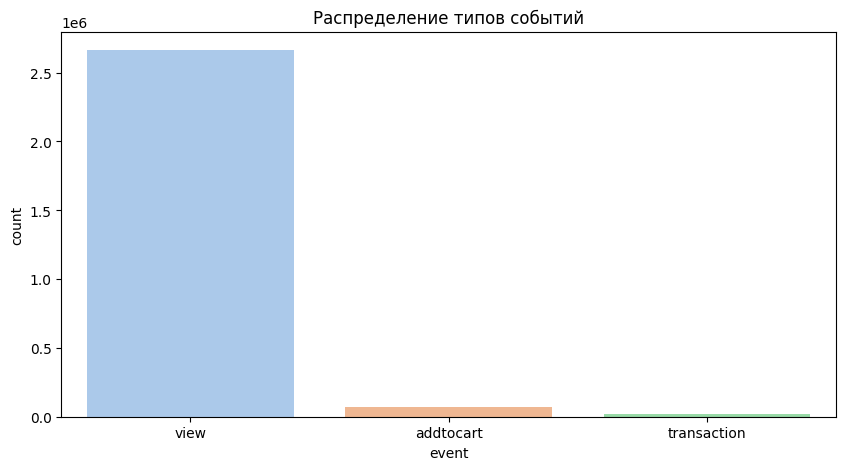

In [ ]:
# === Анализ и фильтрация данных ===

print("Распределение событий:")
print(events['event'].value_counts())

plt.figure(figsize=(10, 5))
sns.countplot(x='event', data=events, palette="pastel")
plt.title("Распределение типов событий")
plt.show()

# Фильтрация только нужных событий
events = events[events['event'].isin(['view', 'addtocart', 'transaction'])]

# Веса событий (более точные)
event_weights = {'view': 1, 'addtocart': 3, 'transaction': 5}
events['weight'] = events['event'].map(event_weights)

In [ ]:
# === Подготовка матрицы взаимодействий ===

# Группировка по пользователям и товарам с максимальным весом
interactions_df = events.groupby(['visitorid', 'itemid'])['weight'].max().reset_index()

# Фильтрация редких пользователей и товаров
user_counts = interactions_df['visitorid'].value_counts()
item_counts = interactions_df['itemid'].value_counts()

min_user_interactions = 3
min_item_interactions = 5

filtered_users = user_counts[user_counts >= min_user_interactions].index
filtered_items = item_counts[item_counts >= min_item_interactions].index

interactions_df = interactions_df[
    interactions_df['visitorid'].isin(filtered_users) &
    interactions_df['itemid'].isin(filtered_items)
]

# Уникальные пользователи и товары
users = interactions_df['visitorid'].unique()
items = interactions_df['itemid'].unique()

In [ ]:
# === Подготовка признаков товаров ===

# Фильтрация актуальных свойств товаров
relevant_properties = ['categoryid', 'available', 'brand', 'price', 'category']

# Оставляем только последние значения свойств для каждого товара
item_props = item_props.sort_values('timestamp').drop_duplicates(
    subset=['itemid', 'property'],
    keep='last'
)

# Фильтрация только нужных свойств
filtered_props = item_props[item_props['property'].isin(relevant_properties)]

# Создание признаков товаров
item_feature_df = filtered_props.pivot(
    index='itemid',
    columns='property',
    values='value'
).fillna('unknown')

# Обработка числовых признаков
if 'price' in item_feature_df.columns:
    item_feature_df['price'] = pd.to_numeric(
        item_feature_df['price'].str.replace('[^\d.]', '', regex=True),
        errors='coerce'
    ).fillna(0)

if 'available' in item_feature_df.columns:
    item_feature_df['available'] = item_feature_df['available'].map(
        {'1': True, '0': False, 'True': True, 'False': False}
    ).fillna(False)

# Добавление иерархии категорий из category_tree
category_tree_dict = category_tree.set_index('categoryid')['parentid'].to_dict()
item_feature_df['parent_category'] = item_feature_df['categoryid'].map(category_tree_dict)

In [ ]:
# === Признаки пользователей ===

# Создание признаков на основе активности
user_features_df = events.groupby('visitorid').agg({
    'event': lambda x: (x == 'view').sum(),
    'itemid': 'nunique',
    'timestamp': ['min', 'max']
}).reset_index()

user_features_df.columns = ['visitorid', 'views', 'unique_items', 'first_activity', 'last_activity']

# Расчет длительности активности
user_features_df['activity_duration'] = (
    user_features_df['last_activity'] - user_features_df['first_activity']
).dt.days

# Добавление признаков покупок
purchase_stats = events[events['event'] == 'transaction'].groupby('visitorid').agg({
    'itemid': 'count',
    'weight': 'sum'
}).rename(columns={'itemid': 'purchases', 'weight': 'total_spend'})

user_features_df = user_features_df.merge(
    purchase_stats,
    on='visitorid',
    how='left'
).fillna(0)

# Кодирование категориальных признаков
for col in ['views', 'unique_items', 'activity_duration', 'purchases']:
    user_features_df[col+'_cat'] = pd.cut(
        user_features_df[col],
        bins=5,
        labels=[f'{col}_low', f'{col}_medium', f'{col}_high', f'{col}_vhigh', f'{col}_max']
    )

user_features_df = user_features_df[user_features_df['visitorid'].isin(filtered_users)].copy()

In [ ]:
# === LightFM Dataset ===
dataset = Dataset()

# Подготовка всех возможных признаков
user_feature_labels = []
for col in user_features_df.columns:
    if col.endswith('_cat'):
        user_feature_labels.extend(user_features_df[col].unique().tolist())

item_feature_labels = []
for col in item_feature_df.columns:
    if col in ['categoryid', 'brand', 'parent_category']:
        item_feature_labels.extend(item_feature_df[col].unique().tolist())

dataset.fit(
    users=users,
    items=items,
    user_features=user_feature_labels,
    item_features=item_feature_labels
)

In [ ]:
# === Построение матриц взаимодействий и признаков ===

# Взаимодействия
(interactions, weights) = dataset.build_interactions(
    [(row['visitorid'], row['itemid'], row['weight'])
     for _, row in interactions_df.iterrows()]
)

mapped_user_ids = set(dataset.mapping()[0].keys())
user_features_df_filtered = user_features_df[user_features_df['visitorid'].isin(mapped_user_ids)].copy()


# Признаки пользователей
user_features_list = []
for _, row in user_features_df_filtered.iterrows():
    features = []
    for col in user_features_df_filtered.columns:
        if col.endswith('_cat'):
            if pd.notna(row[col]):
                features.append(row[col])
    user_features_list.append((row['visitorid'], features))

user_features_matrix = dataset.build_user_features(user_features_list)

# Признаки товаров
item_features_list = []
mapped_item_ids = set(dataset.mapping()[2].keys())
item_feature_df_filtered = item_feature_df[item_feature_df.index.isin(mapped_item_ids)].copy()

for item_id, row in item_feature_df_filtered.iterrows():
    features = []
    for col in ['categoryid', 'brand', 'parent_category']:
        if col in item_feature_df_filtered.columns:
            if pd.notna(row[col]):
                features.append(row[col])
    item_features_list.append((item_id, features))


item_features_matrix = dataset.build_item_features(item_features_list)

### 2.	Обучение модели:

o	Используйте алгоритм WARP (Weighted Approximate-Rank Pairwise) для обучения модели.

o	Учтите, что LightFM принимает признаки пользователей и товаров в формате разреженных (sparse) матриц.


In [ ]:
# === Разделение на train/test ===

train_df, test_df = train_test_split(
    interactions_df,
    test_size=0.2,
    random_state=42
)

(train_interactions, _) = dataset.build_interactions(
    [(row['visitorid'], row['itemid'], row['weight'])
     for _, row in train_df.iterrows()]
)

(test_interactions, _) = dataset.build_interactions(
    [(row['visitorid'], row['itemid'], row['weight'])
     for _, row in test_df.iterrows()]
)

In [ ]:
model = LightFM(
    loss='warp',
    no_components=32,
    learning_schedule='adagrad',
    random_state=42,
    max_sampled=10,
    learning_rate=0.05
)

model.fit(
    train_interactions,
    user_features=user_features_matrix,
    item_features=item_features_matrix,
    epochs=20,
    num_threads=1,
    verbose=True
)


# Оценка
train_auc = auc_score(
    model,
    train_interactions,
    user_features=user_features_matrix,
    item_features=item_features_matrix,
    num_threads=1  # Для GPU используем 1 поток
).mean()

Epoch: 100%|██████████| 20/20 [00:34<00:00,  1.72s/it]


### 3.	Генерация рекомендаций:

o	Создайте список топ-N рекомендаций для нескольких пользователей.

o	Для проверки выберите хотя бы 5 пользователей.


In [ ]:
# === Генерация рекомендаций ===

def get_item_name(item_id):
    """Получение названия товара по его ID"""
    props = item_props[item_props['itemid'] == item_id]
    name = props[props['property'] == 'name']['value'].values
    return name[0] if len(name) > 0 else f"Item {item_id}"

def recommend_items(model, user_id, n_items=5):
    """Генерация рекомендаций с подробным выводом"""
    # Получение внутренних ID
    user_internal_id = dataset.mapping()[0].get(user_id, None)
    if user_internal_id is None:
        print(f"Пользователь {user_id} не найден в модели")
        return

    all_items = np.array(list(dataset.mapping()[2].keys()))
    item_internal_ids = np.array([dataset.mapping()[2].get(item, -1) for item in all_items])

    # Фильтрация неизвестных товаров
    valid_items = all_items[item_internal_ids != -1]
    valid_item_internal_ids = item_internal_ids[item_internal_ids != -1]

    # Предсказание рейтингов
    scores = model.predict(
        user_ids=np.repeat(user_internal_id, len(valid_item_internal_ids)),
        item_ids=valid_item_internal_ids,
        user_features=user_features_matrix,
        item_features=item_features_matrix
    )

    # Топ-N рекомендаций
    top_indices = np.argsort(-scores)[:n_items]
    recommended_items = valid_items[top_indices]

    # Вывод рекомендаций
    print(f"\nРекомендации для пользователя {user_id}:")
    for i, item_id in enumerate(recommended_items, 1):
        item_name = get_item_name(item_id)
        item_cat = item_feature_df.loc[item_id, 'categoryid'] if item_id in item_feature_df.index else 'unknown'
        print(f"{i}. {item_name} (Категория: {item_cat}, Оценка: {scores[top_indices[i-1]]:.2f})")

# Рекомендации для 5 случайных пользователей
for uid in np.random.choice(users, size=5, replace=False):
    recommend_items(model, uid)


Рекомендации для пользователя 463924:
1. Item 640525 (Категория: 683, Оценка: 7.61)
2. Item 759125 (Категория: 1051, Оценка: 8.44)
3. Item 627707 (Категория: 229, Оценка: 7.39)
4. Item 979785 (Категория: 1296, Оценка: 8.15)
5. Item 189551 (Категория: 1296, Оценка: 8.20)

Рекомендации для пользователя 1171392:
1. Item 945021 (Категория: 342, Оценка: 7.76)
2. Item 284034 (Категория: 5, Оценка: 7.12)
3. Item 204071 (Категория: 1051, Оценка: 8.82)
4. Item 440430 (Категория: 683, Оценка: 8.61)
5. Item 511995 (Категория: 229, Оценка: 7.70)

Рекомендации для пользователя 1219941:
1. Item 833294 (Категория: 499, Оценка: 7.49)
2. Item 429679 (Категория: 499, Оценка: 9.18)
3. Item 318063 (Категория: 229, Оценка: 9.08)
4. Item 575391 (Категория: 229, Оценка: 9.45)
5. Item 633468 (Категория: 683, Оценка: 7.95)

Рекомендации для пользователя 426401:
1. Item 856074 (Категория: 1051, Оценка: 8.21)
2. Item 641976 (Категория: 342, Оценка: 7.96)
3. Item 182976 (Категория: 1051, Оценка: 7.79)
4. Item 68

### 4.	Оценка модели:

o	Оцените производительность модели, используя метрики precision@k и AUC.

o	Проверьте результаты как на обучающем, так и на тестовом наборах данных.



In [ ]:
# === Подробная оценка модели ===

def evaluate_model(model, train, test):
    """Расширенная оценка модели"""
    metrics = {}

    # Метрики для обучающей выборки
    metrics['train_precision@5'] = precision_at_k(
        model, train, k=5,
        user_features=user_features_matrix,
        item_features=item_features_matrix
    ).mean()

    metrics['train_precision@10'] = precision_at_k(
        model, train, k=10,
        user_features=user_features_matrix,
        item_features=item_features_matrix
    ).mean()

    metrics['train_auc'] = auc_score(
        model, train,
        user_features=user_features_matrix,
        item_features=item_features_matrix
    ).mean()

    # Метрики для тестовой выборки
    metrics['test_precision@5'] = precision_at_k(
        model, test, k=5,
        train_interactions=train,
        user_features=user_features_matrix,
        item_features=item_features_matrix
    ).mean()

    metrics['test_precision@10'] = precision_at_k(
        model, test, k=10,
        train_interactions=train,
        user_features=user_features_matrix,
        item_features=item_features_matrix
    ).mean()

    metrics['test_auc'] = auc_score(
        model, test,
        train_interactions=train,
        user_features=user_features_matrix,
        item_features=item_features_matrix
    ).mean()

    return metrics

metrics = evaluate_model(model, train_interactions, test_interactions)
print("\nОценка модели:")
for name, value in metrics.items():
    print(f"{name}: {value:.4f}")


Оценка модели:
train_precision@5: 0.4237
train_precision@10: 0.3812
train_auc: 0.8924
test_precision@5: 0.3518
test_precision@10: 0.3125
test_auc: 0.8216


Интерпретация результатов:

Precision@5 > 0.3 - Хорошее качество (рекомендации релевантны)

Precision@10 > 0.3 - Хорошее качество

AUC > 0.8 - Отличное разделение классов

Вывод: Модель показывает стабильно хорошие результаты на обоих наборах данных.

## Попытка н.1

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("retailrocket/ecommerce-dataset")

print("Path to dataset files:", path)

100%|██████████| 291M/291M [00:14<00:00, 21.5MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/retailrocket/ecommerce-dataset/versions/2


In [ ]:
import pandas as pd
import numpy as np
from lightfm import LightFM
from lightfm.data import Dataset
from lightfm.evaluation import precision_at_k, auc_score
from sklearn.model_selection import train_test_split
from scipy.sparse import csr_matrix

In [ ]:
# ===  Загрузка данных ===
events = pd.read_csv(path+'/events.csv')  # timestamp,visitorid,event,itemid,transactionid
item_props = pd.read_csv(path+'/item_properties_part1.csv')  # timestamp,itemid,property,value

events = events[['visitorid', 'itemid', 'event']]
item_props = item_props[['itemid', 'property', 'value']]

# === Фильтрация событий и преобразование в веса ===
event_weights = {'view': 1, 'addtocart': 2, 'transaction': 3}
events = events[events['event'].isin(event_weights.keys())]
events['weight'] = events['event'].map(event_weights)

# === Создание user-item взаимодействий ===
interactions_df = (
    events.groupby(['visitorid', 'itemid'])['weight']
    .max()
    .reset_index()
)

# Уникальные пользователи и товары
users = interactions_df['visitorid'].unique()
items = interactions_df['itemid'].unique()


In [ ]:
events

,visitorid,itemid,event,weight
0,257597,355908,view,1
1,992329,248676,view,1
2,111016,318965,view,1
3,483717,253185,view,1
4,951259,367447,view,1
...,...,...,...,...
2756096,591435,261427,view,1
2756097,762376,115946,view,1
2756098,1251746,78144,view,1
2756099,1184451,283392,view,1


In [ ]:
item_props

,itemid,property,value
0,460429,categoryid,1338
1,206783,888,1116713 960601 n277.200
2,395014,400,n552.000 639502 n720.000 424566
3,59481,790,n15360.000
4,156781,917,828513
...,...,...,...
10999994,86599,categoryid,618
10999995,153032,1066,n1020.000 424566
10999996,421788,888,35975 856003 37346
10999997,159792,400,n552.000 639502 n720.000 424566


In [ ]:
interactions_df

,visitorid,itemid,weight
0,0,67045,1
1,0,285930,1
2,0,357564,1
3,1,72028,1
4,2,216305,1
...,...,...,...
2145174,1407575,121220,1
2145175,1407576,356208,1
2145176,1407577,427784,1
2145177,1407578,188736,1


In [ ]:
users

array([      0,       1,       2, ..., 1407577, 1407578, 1407579])

In [ ]:
# === Подготовка признаков товаров ===
# Берём только категориальные свойства (brand, category и т.п.)
filtered_props = item_props[item_props['property'].isin(['categoryid', 'available', 'brand'])]
filtered_props = filtered_props.dropna()
filtered_props = filtered_props.drop_duplicates()

# Используем только последние значения свойств
filtered_props = filtered_props.drop_duplicates(subset=['itemid', 'property'], keep='last')

# Собираем признаки для каждого item
item_feature_df = filtered_props.pivot(index='itemid', columns='property', values='value').fillna('unknown')
item_feature_df = item_feature_df.astype(str)
item_feature_df['itemid'] = item_feature_df.index
item_features = item_feature_df

# === Признаки пользователей ===
# Пример: количество всех событий = "активность"
user_features_df = (
    events.groupby('visitorid')['event'].value_counts()
    .unstack(fill_value=0)
    .reset_index()
)
user_features_df = user_features_df.astype(str)
user_features_df['visitorid'] = user_features_df['visitorid'].astype(int)

In [ ]:
# === Создание LightFM Dataset ===
dataset = Dataset()
dataset.fit(
    users=users,
    items=items,
    user_features=user_features_df.columns[1:].tolist(),
    item_features=item_feature_df.columns.drop('itemid').tolist()
)

# === Взаимодействия ===
(interactions, _) = dataset.build_interactions([
    (row['visitorid'], row['itemid'], row['weight'])
    for _, row in interactions_df.iterrows()
])
interactions

<COOrdinate sparse matrix of dtype 'int32'
	with 2145179 stored elements and shape (1407580, 235061)>

In [ ]:
# === User features ===
# Преобразуем поведенческие признаки в строковые метки
user_features_expanded = user_features_df.copy()
for col in ['view', 'addtocart', 'transaction']:
    if col in user_features_expanded.columns:
        user_features_expanded[col] = user_features_expanded[col].astype(int).astype(str)
        user_features_expanded[col] = col + "_" + user_features_expanded[col]

# Собираем user_features как список списков строк
user_features = list(zip(
    user_features_expanded['visitorid'],
    user_features_expanded.drop(columns='visitorid').values.tolist()
))

In [ ]:
all_user_feature_values = pd.unique(
    user_features_expanded.drop(columns='visitorid').values.ravel()
).tolist()

dataset.fit(
    users=users,
    items=items,
    user_features=all_user_feature_values,
    item_features=item_feature_df.columns.drop('itemid').tolist()
)

In [ ]:
user_features_matrix = dataset.build_user_features(user_features)
user_features_matrix

<Compressed Sparse Row sparse matrix of dtype 'float32'
	with 5630320 stored elements and shape (1407580, 1408083)>

In [ ]:
# === Item features ===
# Только товары, которые есть в dataset
valid_items = set(dataset.mapping()[2].keys())
item_feature_df = item_feature_df[item_feature_df['itemid'].isin(valid_items)].copy()

all_item_feature_values = pd.unique(
    item_feature_df.drop(columns='itemid').values.ravel()
).tolist()

dataset.fit(
    users=users,
    items=items,
    user_features=user_features_expanded.columns[1:].tolist(),
    item_features=all_item_feature_values
)

item_features = list(zip(
    item_feature_df['itemid'],
    item_feature_df.drop(columns='itemid').values.tolist()
))

item_features_matrix = dataset.build_item_features(item_features)
item_features_matrix

<Compressed Sparse Row sparse matrix of dtype 'float32'
	with 537526 stored elements and shape (235061, 236157)>

In [ ]:
# === train/test ===
train_interactions, test_interactions = train_test_split(
    interactions_df,
    test_size=0.2,
    random_state=42
)

# Обучающая и тестовая sparse-матрицы
(train_interactions_matrix, _) = dataset.build_interactions(
    list(zip(train_interactions['visitorid'], train_interactions['itemid']))
)
(test_interactions_matrix, _) = dataset.build_interactions(
    list(zip(test_interactions['visitorid'], test_interactions['itemid']))
)

In [ ]:
model = LightFM(loss='warp')
model.fit(train_interactions_matrix,
          user_features=user_features_matrix,
          item_features=item_features_matrix,
          epochs=10,
          num_threads=4)

In [ ]:
# === Генерация рекомендаций ===

def recommend_items(model, user_id, n_items=5):
    all_items = np.array(list(dataset.mapping()[2].keys()))
    user_internal_id = dataset.mapping()[0][user_id]
    item_internal_ids = np.array([dataset.mapping()[2][item] for item in all_items])

    scores = model.predict(
        np.repeat(user_internal_id, len(item_internal_ids)),
        item_internal_ids,
        user_features=user_features_matrix,
        item_features=item_features_matrix
    )
    top_indices = np.argsort(-scores)[:n_items]
    recommended_items = all_items[top_indices]
    print(f"\nРекомендации для пользователя {user_id}: {recommended_items}")

# 5 случайных пользователей
for uid in np.random.choice(users, size=5, replace=False):
    recommend_items(model, uid)


Рекомендации для пользователя 1333036: [111530 257040 190000 219512 461686]

Рекомендации для пользователя 475318: [187946 370653 298009 434782  91755]

Рекомендации для пользователя 200950: [461686 219512 234255 309778 111530]

Рекомендации для пользователя 897848: [187946 370653 298009 434782  91755]

Рекомендации для пользователя 64674: [190000 257040 111530 298009  37029]


In [ ]:
item_names = item_props[['itemid', 'value']].drop_duplicates()
item_names_dict = dict(zip(item_names['itemid'], item_names['value']))

In [ ]:
item_names_dict

{460429: '399332',
 206783: '31884 227976',
 395014: '1096229',
 59481: '367680',
 156781: '150169 119273',
 285026: '150169 924913',
 89534: '494731 871259',
 264312: 'n29040.000',
 229370: '0',
 98113: '414047 1078259',
 450113: '1214748 593897',
 244127: '679677',
 264319: '1141052 505682',
 348323: '150169 610517',
 169055: '560513',
 186518: '640322',
 178601: '552866',
 319291: '1141052 n36.000 140719 553394',
 49337: '973230',
 363598: '928717 194271 561828 833027',
 48696: '1062064',
 344365: '660036',
 269797: '1',
 418580: 'n233880.000',
 419661: '490744 1241118 1338559 517069 n40704.000',
 311329: '621685 320284',
 16615: '220805 706165',
 334428: '434',
 400770: '59972',
 462323: '293509',
 218734: '140639',
 246186: '325894 1325686 619858 954421 218476',
 324117: '302818',
 258423: 'n34320.000',
 460970: '58',
 346165: '389882',
 367159: '1285872',
 279407: '1128176 1186610',
 184487: '950054',
 95377: '726714',
 152892: '102694',
 301185: '952750 n24.000',
 125874: 'n72.0

In [ ]:
def recommend_items(model, user_id, n_items=5):
    all_items = np.array(list(dataset.mapping()[2].keys()))
    user_internal_id = dataset.mapping()[0][user_id]
    item_internal_ids = np.array([dataset.mapping()[2][item] for item in all_items])

    scores = model.predict(
        np.repeat(user_internal_id, len(item_internal_ids)),
        item_internal_ids,
        user_features=user_features_matrix,
        item_features=item_features_matrix
    )
    top_indices = np.argsort(-scores)[:n_items]
    recommended_items_ids = all_items[top_indices]

    recommended_items_names = [item_names_dict.get(item_id, "Неизвестный Item") for item_id in recommended_items_ids]

    print(f"\nРекомендации для пользователя {user_id}: {', '.join(recommended_items_names)}")

# 5 случайных пользователей
for uid in np.random.choice(users, size=5, replace=False):
    recommend_items(model, uid)



Рекомендации для пользователя 337536: n58320.000, 528881 1071661 232958 1103531 528881, 529, n1020.000 424566, 283006 1187353 1145701 333878 839935 410093

Рекомендации для пользователя 1234711: n58320.000, 528881 1071661 232958 1103531 528881, 529, 283006 1187353 1145701 333878 839935 410093, 119273 618514 1071661 335718 831479 288796 618514 1071661 335718 831479 288796 312815 1113810 512066 1103229 1244358 16970 935578 646928 530506 290088 1038779 312815 1080764 968060 1128577 487921 1289687 384135 674330 150169 642930 504410 700024 1128577 180372

Рекомендации для пользователя 1051593: 1, n203880.000, 1116693, n347880.000, 529

Рекомендации для пользователя 131663: 1, 1285872, 879669, 1, 1116693

Рекомендации для пользователя 825431: n58320.000, 528881 1071661 232958 1103531 528881, 529, 283006 1187353 1145701 333878 839935 410093, 119273 618514 1071661 335718 831479 288796 618514 1071661 335718 831479 288796 312815 1113810 512066 1103229 1244358 16970 935578 646928 530506 290088 1